# Imports

In [ ]:
%load_ext autoreload
%autoreload 2

import sys 
import glob
import ray
import logging 
import gc
import cv2
import time
import itertools
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import xarray as xr
import matplotlib.gridspec as gridspec

from tqdm.notebook import tqdm
from matplotlib.backends.backend_pdf import PdfPages
from scipy.signal import medfilt
from pathlib import Path
from scipy.optimize import minimize_scalar
from scipy.stats import binned_statistic

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from kornia.geometry.transform import Affine
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sys.path.append(str(Path('.').absolute()))
from utils import *
import io_dict_to_hdf5 as ioh5
from format_data import *
from models import *
from fit_GLM import *
# pd.set_option('display.max_rows', None)

ray.init(
    ignore_reinit_error=True,
    logging_level=logging.ERROR,
)


In [ ]:
args = arg_parser(jupyter=True)
MovModel = 1
Kfold = 0
args['free_move'] = True
if args['free_move']:
    stim_type = 'fm1'
else:
    stim_type = 'hf1_wn'  # 'fm1' #

dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
args['date_ani'] = dates_all[1]
# args['date_ani'] = '070921/J553RT' 
# args['date_ani'] = '101521/J559NC'   
# args['date_ani'] = '102621/J558NC'
# args['date_ani'] = '110421/J569LT'
# yaml_path = sorted(list((Path(args['save_dir']).expanduser() / date_ani / stim_type / 'GLM_Network_NL/').rglob('*.yaml')))
# args['shiftn']=7
args['train_shifter']=False
args['NoL1'] = False
args['Nepochs'] = 5000
params,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)

data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)


if args['NoL1'] == True: 
    L1 = 'NoL1'
    mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
else: 
    L1 = 'withL1'
    mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
ModelList = sorted(list(exp.save_dir.rglob(mod_name+'.h5')))
model_info = params['date_ani2']+'_'+mod_name.replace('*', '')

##### Set Train Test Splits #####
Kfold = 0
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params)
locals().update(data)

# Initialize movement combinations
titles = np.array(['Theta', 'Phi', 'Roll', 'Pitch'])

params, xtr, xtrm, xte, xtem, ytr, yte, shift_in_tr, shift_in_te, input_size, output_size, model_type, meanbias, model_move = load_GLM_data(data, params, train_idx, test_idx)
print('Model: {}, LinMix: {}, move_features: {}, Ncells: {}, train_shifter: {}'.format(params['MovModel'],params['LinMix'],params['move_features'],params['Ncells'],params['train_shifter']))



# Single Model Plot

# Scatter Plot

In [ ]:
mod_titles = ['Mot','Vis','Add','Mul']
mod_clrs = ["#136f63","#e0ca3c","#f34213","#80a4ed"]
move_clrs = ['blue','orange','green','red']
Nepochs = 5000
NKfold=1

vloss_Mot = np.zeros((NKfold,output_size))
vloss_Vis = np.zeros((NKfold,output_size))
vloss_Add = np.zeros((NKfold,output_size))
vloss_Mul = np.zeros((NKfold,output_size))
r2_Mot = np.zeros((NKfold,output_size))
r2_Vis = np.zeros((NKfold,output_size))
r2_Add = np.zeros((NKfold,output_size))
r2_Mul = np.zeros((NKfold,output_size))
for Kfold in range(NKfold):
    params_m0,_,_ = load_params(0,Kfold,args,debug=True)
    params_m1,_,_ = load_params(1,Kfold,args,debug=True)
    params_m2,_,_ = load_params(2,Kfold,args,debug=True)
    params_m3,_,_ = load_params(3,Kfold,args,debug=True)
    data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params_m1, Kfold=Kfold, dataset_type='test')
    GLM_Mot = ioh5.load(ModelList[0])
    GLM_Vis = ioh5.load(ModelList[1])
    GLM_Add = ioh5.load(ModelList[2])
    GLM_Mul = ioh5.load(ModelList[3])
    r2_Mot[Kfold] = GLM_Mot['r2_test'].copy()
    r2_Vis[Kfold] = GLM_Vis['r2_test'].copy()
    r2_Add[Kfold] = GLM_Add['r2_test'].copy()
    r2_Mul[Kfold] = GLM_Mul['r2_test'].copy()
    vloss_Mot[Kfold] = np.mean(GLM_Mot['vloss_trace_all'][:,-10:],axis=1)/np.var(data['test_nsp'],axis=0)
    vloss_Vis[Kfold] = np.mean(GLM_Vis['vloss_trace_all'][:,-10:],axis=1)/np.var(data['test_nsp'],axis=0)
    vloss_Add[Kfold] = np.mean(GLM_Add['vloss_trace_all'][:,-10:],axis=1)/np.var(data['test_nsp'],axis=0)
    vloss_Mul[Kfold] = np.mean(GLM_Mul['vloss_trace_all'][:,-10:],axis=1)/np.var(data['test_nsp'],axis=0)


In [ ]:
celltype_dir = params['data_dir'].parent.parent.parent.parent / 'batch_files/120221_hffm'
celltype_file = celltype_dir / 'pooled_ephys_population_update_120621.pickle'
celltype = pickle.load(open(celltype_file,'rb'))
date_exp = [n for n,da in enumerate(celltype['session'].unique()) if params['date_ani2'] in da][0]
celltype2 = celltype[celltype['session']==celltype['session'].unique()[date_exp]].reset_index(drop=True)
inh = celltype2['exc_or_inh'] == 'inh'
exc = celltype2['exc_or_inh'] == 'exc'
depth = celltype2['hf1_wn_depth_from_layer5']
clust, clabel = pd.factorize(celltype2['movement_psth_type_simple'])
print(celltype['session'].unique()[date_exp])
#[2,4,7,9]

In [ ]:
dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT'] # '102621/J558NC' 

celltype['session'].unique() 

In [ ]:
a = 0; l = 0
thresh_fr = 1
tuning_thresh = .2
fontsize=24
bin_length=40

vals_Mot = np.nanmean(r2_Mot,axis=0)[tuning_sig2]
vals_Vis = np.nanmean(r2_Vis,axis=0)[tuning_sig2]
vals_Add = np.nanmean(r2_Add,axis=0)[tuning_sig2]
vals_Mul = np.nanmean(r2_Mul,axis=0)[tuning_sig2]
tuning_idx = np.where(tuning_sig2)[0]
lims = (0, .6)

fig, axs = plt.subplots(2,2,figsize=(16,16))
##### Vis vs Mot #####
ax = axs[0,0]
ax.scatter(vals_Vis,vals_Mot,30,c='k', label='Mul')
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.set_xlabel('Visual: $r^2$',fontsize=fontsize)
ax.set_ylabel('Position: $r^2$',fontsize=fontsize)
ax.set_yticks(np.arange(0,lims[1],.1))
ax.set_yticklabels(np.round(np.arange(0,lims[1],.1),decimals=1))
for i, txt in enumerate(np.arange(len(vals_Vis))):
    ax.annotate(tuning_idx[i], (vals_Vis[i], vals_Mot[i]),fontsize=10)

##### Vis vs Add/Mul #####
ax = axs[0,1]
ax.scatter(vals_Vis,vals_Add,30,c=mod_clrs[2], label='Add')
ax.scatter(vals_Vis,vals_Mul,30,c=mod_clrs[3], label='Mul')
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.set_xlabel('Visual: $r^2$',fontsize=fontsize)
ax.set_ylabel('Visual & Position: $r^2$',fontsize=fontsize)
ax.set_yticks(np.arange(0,lims[1],.1))
ax.set_yticklabels(np.round(np.arange(0,lims[1],.1),decimals=1))
leg = ax.legend()
for handle, text in zip(leg.legendHandles, leg.get_texts()):
    text.set_color(handle.get_facecolor()[0])
for i, txt in enumerate(np.arange(len(vals_Vis))):
    ax.annotate(tuning_idx[i], (vals_Vis[i], vals_Add[i]),fontsize=10,c=mod_clrs[2])
    ax.annotate(tuning_idx[i], (vals_Vis[i], vals_Mul[i]),fontsize=10,c=mod_clrs[3])

##### MSE #####
diff = vloss_Add[Kfold][tuning_sig2]-vloss_Mul[Kfold][tuning_sig2]
increase = 1-vloss_Vis[Kfold][tuning_sig2]
th = increase>-10

NMul = np.sum(diff[th]>0)
NAdd = np.sum(diff[th]<0)
ax=axs[1,0]
ax.scatter(diff[th],increase[th],c='b',s=20)
ax.axvline(x=0,c='k')
ax.set_ylabel('1-(NLVis_MSE/SD)')
ax.set_xlabel('MSE: Add-Mul')
ax.set_title('NAdd:{}, NMul:{}'.format(NAdd,NMul))
ax.set_ylim(-.05,.25)
ax.set_xlim(-.02,.02)
for i, txt in enumerate(np.arange(len(tuning_idx[th]))):
    ax.annotate(tuning_idx[th][i], (diff[th][i], increase[th][i]),fontsize=10)

##### R2 Explained Variance #####
diff = r2_Mul[Kfold][tuning_sig2]-r2_Add[Kfold][tuning_sig2]
increase = 1-vloss_Vis[Kfold][tuning_sig2]
th = increase>-10

NMul = np.sum(diff[th]>0)
NAdd = np.sum(diff[th]<0)
ax=axs[1,1]
ax.scatter(diff[th],increase[th],c='b',s=20)
ax.axvline(x=0,c='k')
ax.set_ylabel('1-(NLVis_MSE/SD)')
ax.set_xlabel('R2: Mul-Add')
ax.set_title('NAdd:{}, NMul:{}'.format(NAdd,NMul))
ax.set_ylim(-.05,.25)
for i, txt in enumerate(np.arange(len(tuning_idx[th]))):
    ax.annotate(tuning_idx[th][i], (diff[th][i], increase[th][i]),fontsize=10)

plt.tight_layout() 
fig.savefig(params_m1['fig_dir']/('ScatterComparison_'+model_info+'.png'), facecolor='white', transparent=True, bbox_inches='tight')

# Comparison Plots

In [ ]:
save_pdf = True
ncells = data['model_nsp'].shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
hbins = .05

quartiles = np.arange(0,1.25,.25)
spk_percentile2 = np.arange(.125,1.125,.25)

fontsize = 24
params_m0,_,_ = load_params(0,Kfold,args,debug=True)
params_m1,_,_ = load_params(1,Kfold,args,debug=True)
params_m2,_,_ = load_params(2,Kfold,args,debug=True)
params_m3,_,_ = load_params(3,Kfold,args,debug=True)
data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params_m1, Kfold=Kfold, dataset_type='test')
GLM_Mot = ioh5.load(ModelList[0])
GLM_Vis = ioh5.load(ModelList[1])
GLM_Add = ioh5.load(ModelList[2])
GLM_Mul = ioh5.load(ModelList[3])
locals().update(params)
GLM_Vis['sta_all'] = GLM_Vis['Cell_NN.0.weight'].reshape((ncells,params['nt_glm_lag'],)+params['nks'])
sp_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(bin_length), mode='same')/(bin_length * params['model_dt']), axis=0, arr=data['test_nsp'])[bin_length:-bin_length]
pred_smooth_Mot = np.apply_along_axis(lambda m: np.convolve(m, np.ones(bin_length), mode='same')/(bin_length * params['model_dt']), axis=1, arr=GLM_Mot['pred_cv'])[:,bin_length:-bin_length].T
pred_smooth_Vis = np.apply_along_axis(lambda m: np.convolve(m, np.ones(bin_length), mode='same')/(bin_length * params['model_dt']), axis=1, arr=GLM_Vis['pred_cv'])[:,bin_length:-bin_length].T
pred_smooth_Add = np.apply_along_axis(lambda m: np.convolve(m, np.ones(bin_length), mode='same')/(bin_length * params['model_dt']), axis=1, arr=GLM_Add['pred_cv'])[:,bin_length:-bin_length].T
pred_smooth_Mul = np.apply_along_axis(lambda m: np.convolve(m, np.ones(bin_length), mode='same')/(bin_length * params['model_dt']), axis=1, arr=GLM_Mul['pred_cv'])[:,bin_length:-bin_length].T

r2_Mot = np.array([(np.corrcoef(sp_smooth[:,celln],pred_smooth_Mot[:,celln])[0, 1])**2 for celln in range(params['Ncells'])])
r2_Vis = np.array([(np.corrcoef(sp_smooth[:,celln],pred_smooth_Vis[:,celln])[0, 1])**2 for celln in range(params['Ncells'])])
r2_Add = np.array([(np.corrcoef(sp_smooth[:,celln],pred_smooth_Add[:,celln])[0, 1])**2 for celln in range(params['Ncells'])])
r2_Mul = np.array([(np.corrcoef(sp_smooth[:,celln],pred_smooth_Mul[:,celln])[0, 1])**2 for celln in range(params['Ncells'])])
r2_all = np.stack((r2_Mot,r2_Vis,r2_Add,r2_Mul))

# pbar = tqdm([21,25,49,51,61,62,88,117,121,126]) # [12,13,20,25,49,51]) # 
pbar = tqdm(np.arange(ncells))
pdf_name = params_m1['fig_dir']/ ('MoViAdMu_'+model_info+'_CellSummary.pdf')
if save_pdf:
    pdf = PdfPages(pdf_name)
    fig1, axs = plt.subplots(1,r2_all.shape[0],figsize=(20,5))
    for n in range(r2_all.shape[0]):
        ax = axs[n]
        count,edges = np.histogram(r2_all[n],bins=np.arange(0,1,hbins))
        edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
        ax.bar(edges_mid, count/len(r2_all[n]),color=mod_clrs[n],width=hbins, alpha=1)
        ax.set_xticks(np.arange(0,1.2,.2))
        ax.set_xticklabels(np.round(np.arange(0,1.2,.2),decimals=1))
        ax.set_title(mod_titles[n])
        ax.set_xlabel(r'$r^2$')
    plt.tight_layout()
    pdf.savefig()
    plt.close()
for n, celln in enumerate(pbar): 
    fig2 = plt.figure(constrained_layout=False, figsize=(20,10))
    spec2 = gridspec.GridSpec(ncols=5, nrows=3, figure=fig2)
    axs = np.array([fig2.add_subplot(spec2[0, n]) for n in range(params['nt_glm_lag'])])
    axs2b = fig2.add_subplot(spec2[0,-1])
    axs3a = np.array([fig2.add_subplot(spec2[2, n]) for n in range(len(titles))])
    f2_ax6 = fig2.add_subplot(spec2[1, :5//2+1])
    f2_ax7 = fig2.add_subplot(spec2[1, (5//2+1):-1])
    f2_ax8 = fig2.add_subplot(spec2[1,-1])
    f2_ax8b = fig2.add_subplot(spec2[2,-1])
    if MovModel != 0:
        crange = np.max(np.abs(GLM_Vis['sta_all'][celln]))
        for m,ax in enumerate(axs):
            im = ax.imshow(GLM_Vis['sta_all'][celln,m],'RdBu_r',vmin=-crange,vmax=crange)
            cbar = add_colorbar(im)
            ax.axis('off')

    axs2b.plot(GLM_Vis['loss_regcv'][0,:,celln])
    axs2b.set_ylabel('MSE')
    axs2b.set_xlabel(r'$\lambda_n$')
    axs2b.set_title('Best lam:{}'.format(np.nanargmin(GLM_Vis['loss_regcv'][0,:,celln],axis=0)))

    pred_time = np.arange(len(pred_smooth_Vis[:,celln]))*params_m1['model_dt']
    f2_ax6.plot(pred_time,sp_smooth[:,celln], 'k', lw=2, zorder=0)
    f2_ax6.plot(pred_time,pred_smooth_Mot[:,celln],c=mod_clrs[0], lw=2,label='Mot', zorder=4)
    f2_ax6.plot(pred_time,pred_smooth_Vis[:,celln],c=mod_clrs[1], lw=2,label='Vis', zorder=3)
    f2_ax6.plot(pred_time,pred_smooth_Add[:,celln],c=mod_clrs[2], lw=2, label='Vis+Mov', zorder=2)
    f2_ax6.plot(pred_time,pred_smooth_Mul[:,celln],c=mod_clrs[3], lw=2, label='Vis*Mov', zorder=1)
    f2_ax6.set_xlabel('Time (s)')
    f2_ax6.set_ylabel('Spike Rate')
    f2_ax6.legend(labelcolor='linecolor', fontsize=10, handlelength=0, handletextpad=0)


    f2_ax7.plot(GLM_Vis['vloss_trace_all'][celln], label='Vis Te')
    f2_ax7.plot(GLM_Add['vloss_trace_all'][celln], label='Vis+Mov Te')
    f2_ax7.plot(GLM_Mul['vloss_trace_all'][celln], label='Vis*Mov Te')
    f2_ax7.set_xlabel('Batch #')
    f2_ax7.set_ylabel('Loss')
    f2_ax7.legend(labelcolor='linecolor', fontsize=10, handlelength=0, handletextpad=0, fancybox=True)

    w_move_Add = GLM_Add['posNN.Layer0.weight']
    w_move_Mov = GLM_Mul['posNN.Layer0.weight']
    for modeln in range(len(titles)):
        f2_ax8.bar(modeln, w_move_Add[celln,modeln], color=move_clrs[modeln])
        f2_ax8.set_xticks(np.arange(0,len(titles)))
        f2_ax8.set_xticklabels(titles)
        f2_ax8.set_ylabel('GLM Weight')
        f2_ax8.set_title('Add Weights')
        f2_ax8b.bar(modeln, w_move_Mov[celln,modeln], color=move_clrs[modeln])
        f2_ax8b.set_xticks(np.arange(0,len(titles)))
        f2_ax8b.set_xticklabels(titles)
        f2_ax8b.set_ylabel('GLM Weight')
        f2_ax8b.set_title('Mul Weights')

    top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
    for i,modeln in enumerate(range(len(titles))):
        metric = move_data[:,modeln]
        nranges = np.quantile(metric,quartiles)
        stat_range, edges, _ = binned_statistic(metric,nsp_raw[:,celln],statistic='mean',bins=nranges)
        edge_mids = np.quantile(metric,spk_percentile2)#
        # for m in range(len(nranges)-1):
        #     axs[0,modeln].axvspan(nranges[m], nranges[m+1],ymin=0,ymax=1,alpha=0.8, color=colors[m],zorder=0)
        axs3a[modeln].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=move_clrs[modeln])

        axs3a[modeln].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
        axs3a[modeln].set_xlim(-30,30)
        axs3a[modeln].set_xlabel('Angle (deg)',fontsize=fontsize)
        axs3a[modeln].set_ylabel('sp/sec',fontsize=fontsize)
        axs3a[modeln].set_title(titles[modeln],fontsize=fontsize)

    plt.suptitle(' celln: {}\n Mot $r^2$:{:.03f}, Vis $r^2$:{:.03f}, Add $r^2$:{:.03f}, Mult $r^2$:{:.03f}'.format(celln,r2_all[0,celln],r2_all[1,celln],r2_all[2,celln],r2_all[3,celln]))
    plt.tight_layout()
    if save_pdf:
        pdf.savefig()
        plt.close()
if save_pdf:
    pdf.close()



## Tuning Histograms

In [ ]:
clrs = ['blue','orange','green','red']
titles = np.array(['theta', 'phi', 'rho', 'omega'])
fontsize=24
fig, ax = plt.subplots(1,4,figsize=(20,5))
ax = ax.flatten()
dwidth = .1
for modeln in np.arange(len(titles)):
    count,edges = np.histogram(tuning_sig[:,modeln], bins=np.arange(0,1.1,dwidth))
    edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    ax[modeln].bar(edges_mid, count/len(tuning_sig[:,modeln]),color=clrs[modeln],width=dwidth)
    ax[modeln].set_title('$\{}$'.format(titles[modeln].lower()), fontsize=fontsize)
    ax[modeln].set_xlabel('Modulation Index', fontsize=fontsize)
    ax[modeln].set_ylabel('Proportion', fontsize=fontsize)
    ax[modeln].set_xlim(0,1)
#     ax[modeln].set_ylim(0,.2)
plt.tight_layout()
fig.savefig(fig_dir/'Modulation_hist.pdf',facecolor='white', transparent=True, bbox_inches='tight')

In [ ]:
celln = 126
fontsize = 24
fig, axs = plt.subplots(1,4, figsize=(25,5))
# Tuning Curves
for i,modeln in enumerate(range(len(titles))):
    metric = move_data[:,modeln]
    axs[modeln].plot(edge_mids,tuning_curves[celln,modeln],'.-', ms=25, lw=7,c=clrs[modeln])
    axs[modeln].set_xlim(-30,30)
    axs[modeln].set_xlabel('angle (deg)',fontsize=fontsize)
    axs[modeln].set_ylabel('sp/sec',fontsize=fontsize)
    axs[modeln].set_title(r'$\{}$'.format(titles[modeln]),fontsize=fontsize)
    axs[modeln].set_ylim(bottom=0,top=np.nanmax(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
plt.tight_layout()
fig.savefig(fig_dir/'Turning_Curve_cell{}.pdf'.format(celln),facecolor='white', transparent=True, bbox_inches='tight')

# HF Vs FM RFs

In [ ]:
args = arg_parser(jupyter=True)
MovModel = 1
Kfold = 0

args['free_move'] = True
fm_dir = 'fm1' if args['prey_cap']==False else 'fm1_prey'
if args['free_move']:
    stim_type = fm_dir
else:
    stim_type = 'hf1_wn' 
dates_all = ['062921/G6HCK1ALTRN', '070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT'] # '102621/J558NC' 
args['date_ani'] = dates_all[1]
# args['date_ani'] = dates_all[3]

# args['date_ani'] = '110421/J569LT'# args['date_ani']
# args['date_ani'] = '101521/J559NC'
# args['date_ani'] = '102621/J558NC'
params_FM,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)

data, train_idx_list, test_idx_list = load_train_test(file_dict, **params_FM)

##### Set Train Test Splits #####
Kfold = 0
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params_FM)

args['NoL1'] = False
if args['NoL1'] == True: 
    L1 = 'NoL1'
    mod_name = '*Vis_{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_all'.format(L1,int(params_FM['model_dt']*1000), params_FM['nt_glm_lag'], params['Nepochs'],Kfold)
else: 
    L1 = 'withL1'
    mod_name = '*Vis_{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_all'.format(L1,int(params_FM['model_dt']*1000), params_FM['nt_glm_lag'], params['Nepochs'],Kfold)
ModelList_FM = sorted(list(exp.save_dir.rglob(mod_name+'.h5')))


model_vid_sm_shift = ioh5.load(params_FM['save_dir']/'ModelWC_shifted_dt{:03d}_MovModel{:d}.h5'.format(int(params['model_dt']*1000), 1))['model_vid_sm_shift']  # [:,5:-5,5:-5]
rolled_vid = np.hstack([np.roll(model_vid_sm_shift, nframes, axis=0) for nframes in params_FM['lag_list']])  
model_vid = rolled_vid.reshape(model_vid_sm_shift.shape[0],-1)
model_nsp = data['model_nsp']
Ncells = model_nsp.shape[-1]
sta = (model_vid.T @ model_nsp)/np.sum(model_nsp,0,keepdims=True)
FM_RF = sta.T.reshape((Ncells,len(params_FM['lag_list'])) + model_vid_sm_shift.shape[1:])

# Initialize movement combinations
titles = np.array(['Theta', 'Phi', 'Roll', 'Pitch'])
test_nsp_FM = data['test_nsp']
params_FM, xtr, xtrm, xte, xtem, ytr, yte, shift_in_tr, shift_in_te, input_size, output_size, model_type, meanbias, model_move = load_GLM_data(data, params_FM, train_idx, test_idx)

##### Head Fixed Data #####
args['free_move'] = False
fm_dir = 'fm1' if args['prey_cap']==False else 'fm1_prey'
if args['free_move']:
    stim_type = fm_dir
else:
    stim_type = 'hf1_wn' 
# args['date_ani'] = '110421/J569LT'# args['date_ani']
# args['date_ani'] = '102621/J558NC'
params_HF,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)

data, train_idx_list, test_idx_list = load_train_test(file_dict, **params_HF)

##### Set Train Test Splits #####
Kfold = 0
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params_HF)

args['NoL1'] = False
if args['NoL1'] == True: 
    L1 = 'NoL1'
    mod_name = '*Vis_{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_all'.format(L1,int(params_FM['model_dt']*1000), params_FM['nt_glm_lag'], params['Nepochs'],Kfold)
else: 
    L1 = 'withL1'
    mod_name = '*Vis_{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_all'.format(L1,int(params_FM['model_dt']*1000), params_FM['nt_glm_lag'], params['Nepochs'],Kfold)
ModelList_HF = sorted(list(exp.save_dir.rglob(mod_name+'.h5')))

model_vid_sm_shift = ioh5.load(params_HF['save_dir']/'ModelWC_shifted_dt{:03d}_MovModel{:d}.h5'.format(int(params['model_dt']*1000), 1))['model_vid_sm_shift']  # [:,5:-5,5:-5]
rolled_vid = np.hstack([np.roll(model_vid_sm_shift, nframes, axis=0) for nframes in params_HF['lag_list']])  
model_vid = rolled_vid.reshape(model_vid_sm_shift.shape[0],-1)
model_nsp = data['model_nsp']
Ncells = model_nsp.shape[-1]
sta = (model_vid.T @ model_nsp)/np.sum(model_nsp,0,keepdims=True)
HF_RF = sta.T.reshape((Ncells,len(params_HF['lag_list'])) + model_vid_sm_shift.shape[1:])

# Initialize movement combinations
titles = np.array(['Theta', 'Phi', 'Roll', 'Pitch'])
test_nsp_HF = data['test_nsp']
params_HF['Ncells'] = params_FM['Ncells']
print('Model: {}, LinMix: {}, move_features: {}, Ncells: {}, train_shifter: {}'.format(params_FM['MovModel'],params_FM['LinMix'],params_FM['move_features'],params_FM['Ncells'],params_FM['train_shifter']))


In [ ]:
Nepochs = 5000
Kfold = 0
save_dir_fm = params_FM['save_dir_fm'] / 'GLM_Network' / exp.name / 'version_{}'.format(Kfold)
save_dir_hf = params_HF['save_dir_hf'] / 'GLM_Network' / exp.name / 'version_{}'.format(Kfold)
GLM_FM = ioh5.load(ModelList_FM[0])
GLM_HF = ioh5.load(ModelList_HF[0])

GLM_FM['r2_test'][np.isnan(GLM_FM['r2_test'])]=0
GLM_HF['r2_test'][np.isnan(GLM_HF['r2_test'])]=0

malph = 0*np.ones(params_FM['Ncells'],dtype=int)
mlam_FM = np.nanargmax(GLM_FM['r2_test'][0],axis=0) #22*np.ones(params['Ncells'],dtype=int)# 
mlam_HF = np.nanargmax(GLM_HF['r2_test'][0],axis=0) #22*np.ones(params['Ncells'],dtype=int)# 
mlam_FM_mse = np.nanargmin(GLM_FM['loss_regcv'][0],axis=0) #11*np.ones(params['Ncells'],dtype=int)# 
mlam_HF_mse = np.nanargmin(GLM_HF['loss_regcv'][0],axis=0) #11*np.ones(params['Ncells'],dtype=int)# 
cellnum = np.arange(params_FM['Ncells'])

sta_FM = GLM_FM['Cell_NN.0.weight'][malph,mlam_FM_mse,cellnum].reshape((params_FM['Ncells'],params_FM['nt_glm_lag'],)+params_FM['nks'])[:,0,5:-5,5:-5]
sta_HF = GLM_HF['Cell_NN.0.weight'][malph,mlam_HF_mse,cellnum].reshape((params_FM['Ncells'],params_FM['nt_glm_lag'],)+params_FM['nks'])[:,0,5:-5,5:-5]

GLM_FM['sta_all'] = GLM_FM['Cell_NN.0.weight'][malph,mlam_FM_mse,cellnum].reshape((params_FM['Ncells'],params_FM['nt_glm_lag'],)+params_FM['nks'])#[:,:,5:-5,5:-5]
GLM_HF['sta_all'] = GLM_HF['Cell_NN.0.weight'][malph,mlam_HF_mse,cellnum].reshape((params_FM['Ncells'],params_FM['nt_glm_lag'],)+params_FM['nks'])#[:,:,5:-5,5:-5]


In [ ]:
sf = 4
FM_sta_up = np.zeros((GLM_FM['sta_all'].shape[0], GLM_FM['sta_all'].shape[1], sf*(GLM_FM['sta_all'].shape[-2]), sf*(GLM_FM['sta_all'].shape[-1])))
HF_sta_up = np.zeros((GLM_HF['sta_all'].shape[0], GLM_HF['sta_all'].shape[1], sf*(GLM_HF['sta_all'].shape[-2]), sf*(GLM_HF['sta_all'].shape[-1])))
FM_RF_up = np.zeros((FM_RF.shape[0], FM_RF.shape[1], sf*(FM_RF.shape[-2]), sf*(FM_RF.shape[-1])))
HF_RF_up = np.zeros((HF_RF.shape[0], HF_RF.shape[1], sf*(HF_RF.shape[-2]), sf*(HF_RF.shape[-1])))

for n in range(GLM_HF['sta_all'].shape[0]):
    for t in range(GLM_HF['sta_all'].shape[1]):
        HF_sta_up[n, t] = cv2.resize(GLM_HF['sta_all'][n, t], (sf*(GLM_HF['sta_all'].shape[-1]), sf*(GLM_HF['sta_all'].shape[-2])))
for n in range(GLM_FM['sta_all'].shape[0]):
    for t in range(GLM_FM['sta_all'].shape[1]):
        FM_sta_up[n, t] = cv2.resize(GLM_FM['sta_all'][n, t], (sf*GLM_FM['sta_all'].shape[-1], sf*GLM_FM['sta_all'].shape[-2]))

for n in range(FM_RF_up.shape[0]):
    for t in range(FM_RF_up.shape[1]):
        FM_RF_up[n, t] = cv2.resize(FM_RF[n, t], (sf*(FM_RF.shape[-1]), sf*(FM_RF.shape[-2])))
for n in range(HF_RF_up.shape[0]):
    for t in range(HF_RF_up.shape[1]):
        HF_RF_up[n, t] = cv2.resize(HF_RF[n, t], (sf*(HF_RF.shape[-1]), sf*(HF_RF.shape[-2])))

r2_HFFM_sta = np.zeros(params_FM['Ncells'])
for celln in np.arange(params_FM['Ncells']):
    r2_HFFM_sta[celln] = np.corrcoef(sta_HF[celln].flatten(),sta_FM[celln].flatten())[0,1]

In [ ]:
sp_smooth_FM = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params_FM['bin_length']), mode='same')/(params_FM['bin_length'] * params_FM['model_dt']), axis=0, arr=test_nsp_FM)[params_FM['bin_length']:-params_FM['bin_length']]
sp_smooth_HF = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params_FM['bin_length']), mode='same')/(params_FM['bin_length'] * params_FM['model_dt']), axis=0, arr=test_nsp_HF)[params_FM['bin_length']:-params_FM['bin_length']]
pred_smooth_FM = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params_FM['bin_length']), mode='same')/(params_FM['bin_length'] * params_FM['model_dt']), axis=1, arr=GLM_FM['pred_cv'][malph,mlam_FM_mse,cellnum])[:,params_FM['bin_length']:-params_FM['bin_length']].T
pred_smooth_HF = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params_FM['bin_length']), mode='same')/(params_FM['bin_length'] * params_FM['model_dt']), axis=1, arr=GLM_HF['pred_cv'][malph,mlam_HF_mse,cellnum])[:,params_FM['bin_length']:-params_FM['bin_length']].T
r2_FM= np.array([(np.corrcoef(sp_smooth_FM[:,celln],pred_smooth_FM[:,celln])[0, 1])**2 for celln in range(params_FM['Ncells'])])
r2_HF= np.array([(np.corrcoef(sp_smooth_HF[:,celln],pred_smooth_HF[:,celln])[0, 1])**2 for celln in range(params_FM['Ncells'])])
r2_all = np.stack((r2_FM,r2_HF,r2_HFFM_sta))

In [ ]:
save_pdf=True
hbins=.05
mod_titles = ['Mot','Vis','Add','Mul']
mod_clrs = ["#136f63","#e0ca3c","#f34213","#80a4ed"]
move_clrs = ['blue','orange','green','red']
sta_titles = ['FM','HF','FMHF']
# pbar = tqdm([21,25,49,51,61,62,88,117,121,126]) # [12,13,20,25,49,51]) # 
pbar = tqdm(np.arange(params_FM['Ncells']))
pdf_name = params_FM['fig_dir']/ ('FM_HF_RF_MSE_'+model_info+'2.pdf')
if save_pdf:
    pdf = PdfPages(pdf_name)
    fig1, axs = plt.subplots(1,r2_all.shape[0],figsize=(15,5))
    for n in range(r2_all.shape[0]):
        ax = axs[n]
        if n < 2:
            lim0 = 0
            dlim = .2
            xlab = r'$r^2$'
        else: 
            lim0=0
            dlim = .2
            xlab = 'cc'
        count,edges = np.histogram(np.abs(r2_all[n]),bins=np.arange(lim0,1,hbins))
        edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
        ax.bar(edges_mid, count/len(r2_all[n]),color=mod_clrs[n],width=hbins, alpha=1)
        ax.set_xticks(np.arange(lim0,1.2,dlim))
        ax.set_xticklabels(np.round(np.arange(lim0,1.2,dlim),decimals=1))
        ax.set_title(sta_titles[n])
        ax.set_xlabel(xlab)
    plt.tight_layout()
    pdf.savefig()
    plt.close()
for n, celln in enumerate(pbar): 
    fig = plt.figure(constrained_layout=False, figsize=(25,8))
    spec = gridspec.GridSpec(ncols=5, nrows=2, figure=fig)
    axs0 = np.array([fig.add_subplot(spec[0, n]) for n in range(spec.ncols)])
    axs1 = np.array([fig.add_subplot(spec[1, n]) for n in range(spec.ncols)])

    ax = axs0[0]
    crange = np.max(np.abs(FM_RF_up[celln]))
    im = ax.imshow(FM_RF_up[celln,0],'RdBu_r',vmin=-crange,vmax=crange)
    cbar = add_colorbar(im)
    ax.set_title('FM STA')
    
    ax = axs0[1]
    crange = np.max(np.abs(FM_sta_up[celln]))
    im = ax.imshow(FM_sta_up[celln,0],'RdBu_r',vmin=-crange,vmax=crange)
    cbar = add_colorbar(im)
    ax.set_title('FM RF')


    ax = axs0[2]
    ax.plot(sp_smooth_FM[:,celln])
    ax.plot(pred_smooth_FM[:,celln])
    ax.set_title('$r^2$: {:.03f}'.format(r2_FM[celln]))

    ax = axs0[3]
    ax.plot(GLM_FM['loss_regcv'][0,:,celln])
    ax.set_ylabel('MSE')
    ax.set_xlabel(r'$\lambda_n$')
    ax.set_title('Best lam:{}'.format(mlam_FM_mse[celln]))

    ax = axs0[4]
    ax.plot(GLM_FM['r2_test'][0,:,celln])
    ax.set_ylabel('r2')
    ax.set_xlabel(r'$\lambda_n$')
    ax.set_title('Best lam:{}'.format(mlam_FM[celln]))

    ########### Head Fixed plots ###########
    ax = axs1[0]
    crange = np.max(np.abs(HF_RF_up[celln]))
    im = ax.imshow(HF_RF_up[celln,0],'RdBu_r',vmin=-crange,vmax=crange)
    cbar = add_colorbar(im)
    ax.set_title('HF STA')

    ax = axs1[1]
    crange = np.max(np.abs(HF_sta_up[celln]))
    im = ax.imshow(HF_sta_up[celln,0],'RdBu_r',vmin=-crange,vmax=crange)
    cbar = add_colorbar(im)
    ax.set_title('HF RF')

    ax = axs1[2]
    ax.plot(sp_smooth_HF[:,celln])
    ax.plot(pred_smooth_HF[:,celln])
    ax.set_title('$r^2$: {:.03f}'.format(r2_HF[celln]))

    ax = axs1[3]
    ax.plot(GLM_HF['loss_regcv'][0,:,celln])
    ax.set_ylabel('MSE')
    ax.set_xlabel(r'$\lambda_n$')
    ax.set_title('Best lam:{}'.format(mlam_HF_mse[celln]))

    ax = axs1[4]
    ax.plot(GLM_HF['r2_test'][0,:,celln])
    ax.set_ylabel('r2')
    ax.set_xlabel(r'$\lambda_n$')
    ax.set_title('Best lam:{}'.format(mlam_HF[celln]))

    plt.suptitle(' celln: {} FM_HF_RF_CC:{:.03f}'.format(celln,r2_HFFM_sta[celln]))
    plt.tight_layout()

    if save_pdf:
        pdf.savefig()
        plt.close()
if save_pdf:
    pdf.close()


In [ ]:
cells = [25,45,70,117] # 
# cells = [12,20,25] #[43,48,49,51,61,68,70,73,79,86,90,93,99] #np.arange(100)
num_cells = len(cells)
fontsize=24
# fig_dir_presentations = check_path(fig_dir,'PaperFigs') #UT_Austin_Talk

# fig1, axs1 = plt.subplots(2,2,figsize=(10,5),)
fig1 = plt.figure(constrained_layout=False, figsize=(int(5*num_cells),5))
spec2 = gridspec.GridSpec(ncols=num_cells, nrows=2, figure=fig1, wspace=.1,hspace=.05)
axs1 = np.array([fig1.add_subplot(spec2[n,m]) for n in range(2) for m in range(num_cells)]).reshape(2,num_cells)
for n, cell in enumerate(cells):
    crange1 = np.max(np.abs(sta_HF[cell]))
    im1 = axs1[0,n].imshow(sta_HF[cell], 'RdBu_r', vmin=-crange1, vmax=crange1)
    r2_up = np.corrcoef(sta_HF[cell].flatten(),sta_FM[cell].flatten())[0,1]**2
    axs1[0,n].set_title('Unit: {}, $r^2$={:.02f}'.format(n+1,r2_up), fontsize=fontsize)
    crange2 = np.max(np.abs(sta_FM[cell]))
    im2 = axs1[1,n].imshow(sta_FM[cell],'RdBu_r', vmin=-crange2, vmax=crange2)

axs1[0,0].set_ylabel('Head \n fixed', fontsize=fontsize)
axs1[1,0].set_ylabel('Freely \n moving', fontsize=fontsize)

cbar2 = fig1.colorbar(im2, ax=axs1.ravel().tolist())
# cbar2.set_ticks([-crange2, crange2])
# cbar2.set_ticklabels(['Dark', 'Light'])
# cbar2.ax.tick_params(labelsize=fontsize)

for ax in axs1.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
# fig1.savefig(fig_dir/'HF_FM_RFComparison.png', facecolor='white', transparent=True, bbox_inches='tight')

In [ ]:
sf = 4
FM_sta_up = np.zeros((GLM_Vis['sta_all'].shape[0], GLM_Vis['sta_all'].shape[1],sf*GLM_Vis['sta_all'].shape[-2], sf*GLM_Vis['sta_all'].shape[-1]))
HF_sta_up = np.zeros((GLM_HF['sta_all'].shape[0], GLM_HF['sta_all'].shape[1], sf*(GLM_HF['sta_all'].shape[-2]), sf*(GLM_HF['sta_all'].shape[-1])))
for n in range(GLM_HF['sta_all'].shape[0]):
    for t in range(GLM_HF['sta_all'].shape[1]):
        HF_sta_up[n, t] = cv2.resize(GLM_HF['sta_all'][n, t], (sf*(GLM_HF['sta_all'].shape[-1]), sf*(GLM_HF['sta_all'].shape[-2])))
for n in range(GLM_Vis['sta_all'].shape[0]):
    for t in range(GLM_Vis['sta_all'].shape[1]):
        FM_sta_up[n, t] = cv2.resize(GLM_Vis['sta_all'][n, t], (sf*GLM_Vis['sta_all'].shape[-1], sf*GLM_Vis['sta_all'].shape[-2]))


In [ ]:
r2_HFFM_sta = np.zeros(model_nsp.shape[-1])
for celln in np.arange(model_nsp.shape[-1]):
    r2_HFFM_sta[celln] = np.corrcoef(sta_HF[celln].flatten(),sta_FM[celln].flatten())[0,1]

In [ ]:
np.argmax(r2_HFFM_sta)

In [ ]:
thresh_fr = 1
r2_thresh=.05
# r2_sigP = np.nanmean(r2_Mot,axis=0)

r2_sigV = np.nanmean(r2_Vis,axis=0)
r2_sig2 = (r2_sigV>r2_thresh) & (avg_fr>thresh_fr)
r2_idx = np.where(r2_sig2)[0]
np.sum(r2_sig2)

In [ ]:

hbins=.05
fontsize=24
fig, ax = plt.subplots(figsize=(7,7))
count,edges = np.histogram(r2_HFFM_sta,bins=np.arange(-.6,.8,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(r2_HFFM_sta),color='k',width=hbins, alpha=.75)
ax.set_xlabel('RF Correlation',fontsize=fontsize+5)
ax.set_ylabel('Fraction of Units',fontsize=fontsize+5)
ax.set_yticks(np.arange(-.6,.8,.05))
ax.set_yticklabels(np.round(np.arange(-.6,.8,.05),decimals=3),fontsize=fontsize-2)
ax.set_xticks(np.arange(-.6,.8,.2))
ax.set_xticklabels(np.round(np.arange(-.6, .8, .2),decimals=1), fontsize=fontsize-2)
# ax.set_xlim(0,.8)
ax.set_ylim(0,.25)
# fig.savefig(fig_dir/'HFFM_RF_CCHist.pdf', facecolor='white', transparent=True, bbox_inches='tight')


In [ ]:

cells = [25,117,49,70,90] # 
# cells = np.arange(params['Ncells'])
# cells = [12,20,25,68] #np.arange(18)
# cells = [43,48,49,51,61,68,70,73,79,86,90,93,99] #np.arange(100)

num_cells = len(cells)
fontsize=24
# fig_dir_presentations = check_path(fig_dir,'PaperFigs') #UT_Austin_Talk
xcut1=5
xcut2=-5
ycut1=5
ycut2=-5
# fig1, axs1 = plt.subplots(2,2,figsize=(10,5),)
fig1 = plt.figure(constrained_layout=False, figsize=(int(5*num_cells),5))
spec2 = gridspec.GridSpec(ncols=num_cells, nrows=2, figure=fig1, wspace=.1,hspace=.05)
axs1 = np.array([fig1.add_subplot(spec2[n,m]) for n in range(2) for m in range(num_cells)]).reshape(2,num_cells)
for n, cell in enumerate(cells):
    r2_up = np.corrcoef(sta_HF[cell,xcut1:xcut2,ycut1:ycut2].flatten(),sta_FM[cell,xcut1:xcut2,ycut1:ycut2].flatten())[0,1]
    crange2 = np.max(np.abs(FM_sta_up[cell,0,int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)]))
    im2 = axs1[0,n].imshow(FM_sta_up[cell, 0,int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)],'RdBu_r', vmin=-crange2, vmax=crange2)
    crange1 = np.max(np.abs(HF_sta_up[cell,0,int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)]))
    im1 = axs1[1,n].imshow(HF_sta_up[cell, 0,int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)], 'RdBu_r', vmin=-crange1, vmax=crange1)
    axs1[0,n].set_title('Unit: {}, CC={:.02f}'.format(n+1,r2_up), fontsize=fontsize)

axs1[1,0].set_ylabel('Head \n fixed', fontsize=fontsize)
axs1[0,0].set_ylabel('Freely \n moving', fontsize=fontsize)

cbar2 = fig1.colorbar(im1, ax=axs1.ravel().tolist())
cbar2.set_ticks([-crange1, crange1])
cbar2.set_ticklabels(['Dark', 'Light'])
cbar2.ax.tick_params(labelsize=fontsize)

for ax in axs1.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])    
# fig1.savefig(fig_dir/'HF_FM_RF_CCComparison.png', facecolor='white', transparent=True, bbox_inches='tight')

In [ ]:
# cells = [25,70,90,117] # 49
cells = [12,20,25,68] #np.arange(18)
num_cells = len(cells)

fig1 = plt.figure(constrained_layout=False, figsize=(int(5*params['nt_glm_lag']),int(3*num_cells)))
spec2 = gridspec.GridSpec(ncols=params['nt_glm_lag'], nrows=num_cells, figure=fig1, wspace=.05,hspace=.1)
axs1 = np.array([fig1.add_subplot(spec2[n,m]) for n in range(num_cells) for m in range(params['nt_glm_lag'])]).reshape(num_cells,params['nt_glm_lag'])
for n, cell in enumerate(cells):
    crange2 = np.max(np.abs(FM_sta_up[cell]))
    for lag in range(params['nt_glm_lag']):
        im2 = axs1[n,lag].imshow(FM_sta_up[cell, lag],'RdBu_r', vmin=-crange2, vmax=crange2)
        axs1[0,lag].set_title('Lag:{:03d} ms'.format(int(1000*params['lag_list'][lag]*params['model_dt'])),fontsize=fontsize)
    axs1[n,0].set_ylabel('Unit {}'.format(n+1),fontsize=fontsize)
cbar2 = fig.colorbar(im2, ax=axs1.ravel().tolist())
cbar2.set_ticks([-crange2, crange2])
cbar2.set_ticklabels(['Dark', 'Light'])
cbar2.ax.tick_params(labelsize=fontsize)

for ax in axs1.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

# fig1.savefig(fig_dir/'Example_FM_RFs.png', facecolor='white', transparent=True, bbox_inches='tight')
# print('Saved to: {}'.format(FigPath_SFN/'FM_RFs.png'))

In [ ]:
GLM_HF['r2_test'][r2_HFFM_sta>.09].shape[0],GLM_HF['r2_test'].shape[0]

In [ ]:
fig, ax = plt.subplots()
im=ax.scatter(GLM_HF['r2_test'][r2_HFFM_sta>.09],GLM_Vis['r2_test'][r2_HFFM_sta>.09],c=r2_HFFM_sta[r2_HFFM_sta>.09],cmap='cool')
ax.set_xlabel('Head-Fixed $r^2$')
ax.set_ylabel('Free-Moving $r^2$')
cbar = add_colorbar(im)

In [ ]:
##### Plot All Cells #####
cells = np.argpartition(r2_HFFM_sta, -127)[-127:]
num_cells = len(cells)
fontsize=24
# fig_dir_presentations = check_path(fig_dir,'PaperFigs') #UT_Austin_Talk

# fig1, axs1 = plt.subplots(2,2,figsize=(10,5),)
fig1 = plt.figure(constrained_layout=False, figsize=(int(5*num_cells),5))
spec2 = gridspec.GridSpec(ncols=num_cells, nrows=2, figure=fig1, wspace=.1,hspace=.05)
axs1 = np.array([fig1.add_subplot(spec2[n,m]) for n in range(2) for m in range(num_cells)]).reshape(2,num_cells)
for n, cell in enumerate(cells):
    r2_up = np.corrcoef(sta_HF[cell,xcut1:xcut2,ycut1:ycut2].flatten(),sta_FM[cell,xcut1:xcut2,ycut1:ycut2].flatten())[0,1]
    crange2 = np.max(np.abs(FM_sta_up[cell,0,int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)]))
    im2 = axs1[0,n].imshow(FM_sta_up[cell, 0,int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)],'RdBu_r', vmin=-crange2, vmax=crange2)
    crange1 = np.max(np.abs(HF_sta_up[cell,0,int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)]))
    im1 = axs1[1,n].imshow(HF_sta_up[cell, 0,int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)], 'RdBu_r', vmin=-crange1, vmax=crange1)
    axs1[0,n].set_title('Unit: {}, CC={:.02f}'.format(n+1,r2_up), fontsize=fontsize)

axs1[1,0].set_ylabel('Head \n fixed', fontsize=fontsize)
axs1[0,0].set_ylabel('Freely \n moving', fontsize=fontsize)

cbar2 = fig1.colorbar(im2, ax=axs1.ravel().tolist())
cbar2.set_ticks([-crange2, crange2])
cbar2.set_ticklabels(['Dark', 'Light'])
cbar2.ax.tick_params(labelsize=fontsize)

for ax in axs1.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])  
plt.tight_layout()  
plt.close()
fig1.savefig(params['fig_dir']/'HF_FM_RFComparison_sorted.pdf', facecolor='white', transparent=True, bbox_inches='tight')

In [ ]:
params['fig_dir']

### HF predicts FM

In [ ]:
params['free_move']=False
data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params)

In [ ]:
Nepochs = 12000
Kfold = 0
GLM_Vis = ioh5.load(save_dir_fm/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), params['nt_glm_lag'], 1, Nepochs, Kfold))
GLM_HF = ioh5.load(save_dir_hf/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), params['nt_glm_lag'], 1, Nepochs))
w_FM = torch.from_numpy(GLM_Vis['sta_all'].reshape(GLM_Vis['sta_all'].shape[0],-1)).to(device)
w_HF = torch.from_numpy(GLM_HF['sta_all'].reshape(GLM_HF['sta_all'].shape[0],-1)).to(device)

In [ ]:

l1 = PoissonGLM_AddMult(input_size,output_size,
                        reg_alph=None,reg_alphm=None,move_features=None,
                        meanfr=meanbias,init_sta=w_FM,
                        train_shifter=False,
                        LinMix=False,NonLinLayer=False, device=device,).to(device)


# GLM_Network = GLM_HF
# key_list = ['sta_all','bias', 'w_move','biasm']

# param_dict = {}
# for (pname, param),key in zip(l1.named_parameters(),key_list):
#     if key == 'sta_all':
#         param_dict[pname] = torch.from_numpy(GLM_Network[key].reshape(data['model_nsp'].shape[-1],-1).astype(np.float32))
#     else: 
#         param_dict[pname] = torch.from_numpy(GLM_Network[key].astype(np.float32))
# l1.load_state_dict(param_dict)

In [ ]:
out = l1(xtr, xtrm,shift_in_tr)
loss = l1.loss(out, ytr)
pred = l1(xte, xtem,shift_in_te)
val_loss = l1.loss(pred, yte)
pred_test2 = pred.detach().cpu().numpy()

In [ ]:
celln = 25
bin_length=40
fig,ax = plt.subplots(figsize=(20,5))
GLM_Network = GLM_HF # GLM_Vis #
sp_smooth = ((np.convolve(GLM_Network['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
pred_smooth1 = ((np.convolve(GLM_Network['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
pred_smooth2 = ((np.convolve(pred_test2[:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
# sp_smooth = (sp_smooth-np.nanmean(sp_smooth))/np.max(sp_smooth-np.nanmean(sp_smooth))
# pred_smooth_Vis = (pred_smooth_Vis-np.nanmean(pred_smooth_Vis))/np.max(pred_smooth_Vis-np.nanmean(pred_smooth_Vis))
# pred_smooth1 = (pred_smooth1-np.nanmean(pred_smooth1))/np.max(pred_smooth1-np.nanmean(pred_smooth1))


ax.plot(np.arange(len(sp_smooth))*params['model_dt'],sp_smooth, 'k', lw=2)
ax.plot(np.arange(len(pred_smooth1))*params['model_dt'],pred_smooth1,'r', lw=3)
ax.plot(np.arange(len(pred_smooth2))*params['model_dt'],pred_smooth2,'g', lw=2)
r2_01 = np.corrcoef(sp_smooth,pred_smooth1)[0,1]**2
r2_02 = np.corrcoef(sp_smooth,pred_smooth2)[0,1]**2
r2_12 = np.corrcoef(pred_smooth1,pred_smooth2)[0,1]**2
ax.set_title('$r^2 (01)$: {:.02f}, $r^2 (02)$: {:.02f}, $r^2 (12)$: {:.02f} '.format(r2_01,r2_02,r2_12))
ax.legend(['Actual (0)','Trained Weights: FM (1)', 'Used weights: HF (2)'], loc='upper left')
fig.savefig(fig_dir/'HFData_FMW_Cell{}.png'.format(celln), facecolor='white', transparent=True, bbox_inches='tight')

In [ ]:
# FM Data HF Weights
r2_HM_FM2 = np.zeros((3,output_size))
for celln in range(output_size):
    sp_smooth = ((np.convolve(GLM_Vis['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
    pred_smooth1 = ((np.convolve(GLM_Vis['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
    pred_smooth2 = ((np.convolve(pred_test2[:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
    r2_HM_FM2[0,celln] = np.corrcoef(sp_smooth,pred_smooth1)[0,1]**2
    r2_HM_FM2[1,celln] = np.corrcoef(sp_smooth,pred_smooth2)[0,1]**2
    r2_HM_FM2[2,celln] = np.corrcoef(pred_smooth1,pred_smooth2)[0,1]**2

In [ ]:
r2_HM_FM = np.zeros((3,output_size))
for celln in range(output_size):
    sp_smooth = ((np.convolve(GLM_HF['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
    pred_smooth1 = ((np.convolve(GLM_HF['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
    pred_smooth2 = ((np.convolve(pred_test2[:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
    r2_HM_FM[0,celln] = np.corrcoef(sp_smooth,pred_smooth1)[0,1]**2
    r2_HM_FM[1,celln] = np.corrcoef(sp_smooth,pred_smooth2)[0,1]**2
    r2_HM_FM[2,celln] = np.corrcoef(pred_smooth1,pred_smooth2)[0,1]**2

In [ ]:
thresh = .09

inds = r2_HFFM_sta>thresh

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].scatter(r2_HM_FM[0,inds],r2_HM_FM[1,inds])
axs[0].set_xlabel('HF_W w/ HF_data $r^2$')
axs[0].set_ylabel('FM_W w/ HF_data $r^2$')
axs[0].set_ylim(-.05,.5)

axs[1].scatter(r2_HM_FM2[0,inds],r2_HM_FM2[1,inds])
axs[1].set_xlabel('FM_W w/ FM_data $r^2$')
axs[1].set_ylabel('HF_W w/ FM_data $r^2$')
axs[1].set_ylim(-.05,.5)
plt.tight_layout()
fig.savefig(fig_dir/'SwappingWeights.png', facecolor='white', transparent=True, bbox_inches='tight')

### Testing Gabors

In [ ]:

def gabor(sigma, theta, Lambda, psi, gamma):
    """Gabor feature extraction."""
    sigma_x = sigma
    sigma_y = float(sigma) / gamma

    # Bounding box
    nstds = 3  # Number of standard deviation sigma
    xmax = max(abs(nstds * sigma_x * np.cos(theta)), abs(nstds * sigma_y * np.sin(theta)))
    xmax = np.ceil(max(1, xmax))
    ymax = max(abs(nstds * sigma_x * np.sin(theta)), abs(nstds * sigma_y * np.cos(theta)))
    ymax = np.ceil(max(1, ymax))
    xmin = -xmax
    ymin = -ymax
    # (y, x) = np.meshgrid(np.arange(ymin, ymax + 1), np.arange(xmin, xmax + 1))
    (y, x) = np.meshgrid(np.arange(-15, 15 + 1), np.arange(-10, 10 + 1))

    # Rotation
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)

    gb = np.exp(-.5 * (x_theta ** 2 / sigma_x ** 2 + y_theta ** 2 / sigma_y ** 2)) * np.cos(2 * np.pi / Lambda * x_theta + psi)
    return gb

In [ ]:
celln = 90
gb = gabor(2,5,10,2,1)
fig,axs = plt.subplots(2,1,figsize=(5,8))
axs[0].imshow(gb)
axs[1].imshow(sta_FM[celln])

# Position FR Plots

In [ ]:
GLM_Mot = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Mot',int(params['model_dt']*1000), params['nt_glm_lag'], 0, 12000))
GLM_Vis = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), params['nt_glm_lag'], 1, Nepochs))
GLM_Add = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Add',int(params['model_dt']*1000), params['nt_glm_lag'], 2, Nepochs))
GLM_Mul = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Mul',int(params['model_dt']*1000), params['nt_glm_lag'], 2, Nepochs))


In [ ]:
celln = 126
bin_length=40
titles = np.array(['theta', 'phi', 'rho', 'omega'])
clrs = ['blue', 'orange', 'green', 'red']

fig, axs = plt.subplots(4,1,figsize=(20,20))
for modeln in np.arange(len(titles)):
    ax = axs[modeln]
    sp_smooth = ((np.convolve(GLM_Add['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    # pred_smooth_Vis = ((np.convolve(GLM_Vis['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    # pred_smooth_Add = ((np.convolve(GLM_Add['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    # pred_smooth_Mul = ((np.convolve(GLM_Mul['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    ax.plot(np.arange(len(sp_smooth))*model_dt, (sp_smooth-np.mean(sp_smooth)) /np.max(sp_smooth-np.mean(sp_smooth)), 'k', lw=3, label='V1 Firing Rate')
    # ax.plot(np.arange(len(pred_smooth_Vis))*model_dt,(pred_smooth_Vis-np.mean(pred_smooth_Vis))/np.max(pred_smooth_Vis),'g', lw=2,label='Vis')
    # ax.plot(np.arange(len(pred_smooth_Add))*model_dt,(pred_smooth_Add-np.mean(pred_smooth_Add))/np.max(pred_smooth_Add),'b', lw=2, label='Vis+Mov')
    # ax.plot(np.arange(len(pred_smooth_Mul))*model_dt,(pred_smooth_Mul-np.mean(pred_smooth_Mul))/np.max(pred_smooth_Mul),'r', lw=2, label='Vis*Mov')
    smooth_move = np.zeros((len(titles), sp_smooth.shape[0]))
    smooth1 = ((np.convolve(move_test[:,modeln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    smooth_move[modeln] = (smooth1 - np.nanmean(smooth1))/np.max(smooth1)
    ax.plot(np.arange(smooth_move[modeln].shape[0])*model_dt, smooth_move[modeln],c=clrs[modeln], label=r'$\{}$'.format(titles[modeln]),alpha=.75)
    ax.set_xlabel('Time (s)')
    ax.set_yticks(np.arange(-1,2,1))
    ax.legend(labelcolor='linecolor', fontsize=18, handlelength=0, handletextpad=0)


# Shifter Network


## Save best shifter

In [ ]:
args = arg_parser(jupyter=True)
MovModel = 1
Kfold = 0
args['free_move'] = True
fm_dir = 'fm1' if args['prey_cap']==False else 'fm1_prey'
if args['free_move']:
    stim_type = fm_dir
else:
    stim_type = 'hf1_wn'  # 'fm1' #
    
dates_all = ['062921/G6HCK1ALTRN', '070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT'] # '102621/J558NC' 
args['date_ani'] = dates_all[3]
# args['date_ani'] = '062921/G6HCK1ALTRN'    
# args['date_ani'] = '070921/J553RT'    
# args['date_ani'] = '101521/J559NC'
# args['date_ani'] = '102621/J558NC'
# args['date_ani'] = '110421/J569LT'
# yaml_path = sorted(list((Path(args['save_dir']).expanduser() / date_ani / stim_type / 'GLM_Network_NL/').rglob('*.yaml')))
# args['shiftn']=7
args['train_shifter']=True
args['NoL1'] = True
args['do_norm']=True
params_m1,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)

data, train_idx_list, test_idx_list = load_train_test(file_dict, **params_m1)
ModelList = sorted(list(exp.save_dir.rglob('*_best.h5')))

if args['NoL1'] == True: 
    L1 = 'NoL1'
    ModelList = [ModelList[n] for n in range(len(ModelList)) if ('NoL1' in ModelList[n].as_posix()) &('Shifter' not in ModelList[n].as_posix())]
else: 
    L1 = 'withL1'
    ModelList = [ModelList[n] for n in range(len(ModelList)) if ('NoL1' not in ModelList[n].as_posix()) &('Shifter' not in ModelList[n].as_posix())]

##### Set Train Test Splits #####
Kfold = 0
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params_m1)
locals().update(data)

# Initialize movement combinations
titles = np.array(['Theta', 'Phi', 'Roll', 'Pitch'])

params, xtr, xtrm, xte, xtem, ytr, yte, shift_in_tr, shift_in_te, input_size, output_size, model_type, meanbias, model_move = load_GLM_data(data, params_m1, train_idx, test_idx)
print('Model: {}, LinMix: {}, move_features: {}, Ncells: {}, train_shifter: {}'.format(params['MovModel'],params['LinMix'],params['move_features'],params['Ncells'],params['train_shifter']))


In [ ]:
mean_thresh = np.nanmean(data['model_nsp']/params['model_dt'],axis=0)<1
f25,l75=int((data['model_nsp'].shape[0])*.5),int((data['model_nsp'].shape[0])*.5)
scaled_fr = (np.nanmean(data['model_nsp'][:f25], axis=0)/np.nanstd(data['model_nsp'][:f25], axis=0) - np.nanmean(data['model_nsp'][l75:], axis=0)/np.nanstd(data['model_nsp'][l75:], axis=0))/params['model_dt']
bad_cells = np.where((mean_thresh | (np.abs(scaled_fr)>4)))[0]
np.where(mean_thresh), np.where(np.abs(scaled_fr) > 4)


data['model_nsp'] = np.delete(data['model_nsp'], bad_cells, axis=1)
data['unit_nums'] = np.delete(data['unit_nums'], bad_cells, axis=0)


In [ ]:
(params['save_dir_hf']/'bad_cells.npy').exists()


In [ ]:


bin_length=40
smooth_nsp = np.apply_along_axis(lambda m: np.convolve(m, np.ones(bin_length), mode='same')/(bin_length * params['model_dt']), axis=0, arr=data['model_nsp'])[bin_length:-bin_length].T
smooth_mean = np.apply_along_axis(lambda m: np.convolve(m, np.ones(bin_length), mode='same')/(bin_length * params['model_dt']), axis=0, arr=data['model_nsp'][:,mean_thresh])[bin_length:-bin_length].T

In [ ]:
celln = 64
count[0],np.sum(count[1:]), np.sum(smooth_nsp[celln]==0),np.sum(smooth_nsp[celln]!=0)

In [ ]:
(count,bins,im) = plt.hist(smooth_nsp[42],np.arange(0,100))

In [ ]:
celln = bad_cells
fig,axs = plt.subplots(len(bad_cells),1,figsize=(10,len(bad_cells)*4))

for celln,ax in zip(bad_cells,axs):
    ax.plot(smooth_nsp[celln].T)
    ax.set_title('Celln:{}'.format(celln))

plt.tight_layout()
plt.show()

In [ ]:
save_dir_fm = params['save_dir_fm'] /'GLM_Network/MovModel1/version_0'
save_datafile = save_dir_fm/'GLM_{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}_best.h5'.format(model_type, int(params['model_dt']*1000), params['nt_glm_lag'], params['MovModel'], 2000,Kfold)
GLM_CV = ioh5.load(save_datafile)


In [ ]:
list(save_dir_fm.rglob('*VisShifter*_best.h5'))

In [ ]:
plt.plot(np.nanmean(GLM_CV['loss_regcv'][0,:],axis=-1))
best_shifter = np.nanargmin(np.nanmean(GLM_CV['loss_regcv'][0,:],axis=-1))
best_shifter

In [ ]:
##### Load single shifter network and shift videos #####
reg_alph=a=0; l=best_shifter
print(best_shifter)
Kfold=0
shift_in=3
shift_hidden=50
shift_out=3
save_model_fm = params['save_model_shift'].parent.parent.parent / fm_dir / 'models/Shifter'

shifter_nn = nn.Sequential(
                nn.Linear(shift_in,shift_hidden),
                nn.Softplus(),
                nn.Linear(shift_hidden, shift_out))#.to(device)
model_name = 'GLM_{}_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}_Kfold{:01d}.pth'.format('Pytorch_VisShifter_NoL1','UC',int(.05*1000), 1, MovModel, 2000,a,l,Kfold)
# model_name = 'GLMShifter_WCUC_dt050_T01_MovModel1_NB5000_alph0_lam7.pth'
checkpoint = torch.load(save_model_fm/model_name)
pretrained_dict = {'.'.join(k.split('.')[1:]): v for k, v in checkpoint['model_state_dict'].items() if 'shift' in k}
shifter_nn.load_state_dict(pretrained_dict)

shift_out = shifter_nn(torch.from_numpy(model_move[:,(0,1,3)].astype(np.float32)))#.to(device))
shift = Affine(angle=torch.clamp(shift_out[:,-1],min=-45,max=45),translation=torch.clamp(shift_out[:,:2],min=-20,max=20))
vid_tensor=torch.from_numpy(data['model_vid_sm'][:,np.newaxis].astype(np.float32))#.to(device)
model_vid_sm_shift = shift(vid_tensor.contiguous()).detach().numpy().squeeze()
model_vid_sm_shift2 = {'model_vid_sm_shift':model_vid_sm_shift}
shift_vid_file = params['save_dir']/'ModelWC_shifted_dt{:03d}_MovModel{:d}.h5'.format(int(params['model_dt']*1000), 1)
ioh5.save(shift_vid_file,model_vid_sm_shift2)
print(shift_vid_file)

In [ ]:
t = 1000
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].imshow(data['model_vid_sm'][t], cmap='gray')
axs[1].imshow(model_vid_sm_shift[t], cmap='gray')
print(model_move[t,(0,1,3)],shift_out[t])

In [ ]:
sta_all =checkpoint['model_state_dict']['Cell_NN.0.weight'].reshape((params['Ncells'],params['nt_glm_lag'],)+params['nks']).cpu().detach().numpy()
celln = 0
fig,ax = plt.subplots()
crange = np.max(np.abs(sta_all[celln,0]))
im = ax.imshow(sta_all[celln,0],'RdBu_r',vmin=-crange,vmax=crange)
cbar = add_colorbar(im)
ax.axis('off')

## HF & FM Move Checks

In [ ]:
hftofm_imu_file = '/home/seuss/Research/SensoryMotorPred_Data/data/070921/J553RT/fm1/110521_J569LT_control_Rig2_hf_to_fm_transfer_imu.nc'
imu_data = xr.open_dataset(hftofm_imu_file)
accT = imu_data.IMU_data.sample # imu timestamps
acc_chans = imu_data.IMU_data # imu dample data
# raw gyro values
gx = np.array(acc_chans.sel(channel='gyro_x_raw'))
gy = np.array(acc_chans.sel(channel='gyro_y_raw'))
gz = np.array(acc_chans.sel(channel='gyro_z_raw'))
# gyro values in degrees
gx_deg = np.array(acc_chans.sel(channel='gyro_x'))
gy_deg = np.array(acc_chans.sel(channel='gyro_y'))
gz_deg = np.array(acc_chans.sel(channel='gyro_z'))
# pitch and roll in deg
medfiltbins = 11
groll = medfilt(np.array(acc_chans.sel(channel='roll')),medfiltbins)
gpitch = medfilt(np.array(acc_chans.sel(channel='pitch')),medfiltbins)
eye_file = '/home/seuss/Goeppert/freely_moving_ephys/ephys_recordings/070921/J553RT/hf1_wn/070921_J553RT_control_Rig2_hf1_wn_REYE.nc'
eye_data = xr.open_dataset(eye_file)

eye_params = eye_data['REYE_ellipse_params']

th = np.array((eye_params.sel(ellipse_params = 'theta')*180/np.pi))#-np.nanmean(eye_params.sel(ellipse_params = 'theta')))*180/3.14159)
phi = np.array((eye_params.sel(ellipse_params = 'phi')*180/np.pi))#-np.nanmean(eye_params.sel(ellipse_params = 'phi')))*180/3.14159)


In [ ]:
fmimu_file = list((params['data_dir'].parent / stim_type).glob('*imu.nc'))[0]
imu_data = xr.open_dataset(fmimu_file)
accT = imu_data.IMU_data.sample # imu timestamps
acc_chans = imu_data.IMU_data # imu dample data
# raw gyro values
gx = np.array(acc_chans.sel(channel='gyro_x_raw'))
gy = np.array(acc_chans.sel(channel='gyro_y_raw'))
gz = np.array(acc_chans.sel(channel='gyro_z_raw'))
# gyro values in degrees
gx_deg = np.array(acc_chans.sel(channel='gyro_x'))
gy_deg = np.array(acc_chans.sel(channel='gyro_y'))
gz_deg = np.array(acc_chans.sel(channel='gyro_z'))
# pitch and roll in deg
groll = medfilt(np.array(acc_chans.sel(channel='roll')),11)
gpitch = medfilt(np.array(acc_chans.sel(channel='pitch')),11)

eye_file = list((Path('~/Goeppert/freely_moving_ephys/ephys_recordings/').expanduser() / args['date_ani'] / stim_type).glob('*REYE.nc'))[0]
eye_data = xr.open_dataset(eye_file)
eyeT = eye_data.timestamps.copy()
eye_params = eye_data['REYE_ellipse_params']

th = np.array((eye_params.sel(ellipse_params = 'theta'))*180/np.pi)#-np.nanmean(eye_params.sel(ellipse_params = 'theta')))*180/3.14159)
phi = np.array((eye_params.sel(ellipse_params = 'phi'))*180/np.pi)#-np.nanmean(eye_params.sel(ellipse_params = 'phi')))*180/3.14159)
# fm_eye = {'avg_th': np.nanmean(th),'avg_phi': np.nanmean(phi)}
# ioh5.save(save_dir/'FM_AvgEye_dt{:03d}.h5'.format(int(params['model_dt']*1000)),fm_eye)
FM_move_avg = np.zeros((2,4))
FM_move_avg[:,0] = np.array([np.nanmean(th),np.nanstd(th)])
FM_move_avg[:,1] = np.array([np.nanmean(phi),np.nanstd(phi)])
FM_move_avg[:,2] = np.array([np.nanmean(groll),np.nanstd(groll)])
FM_move_avg[:,3] = np.array([np.nanmean(gpitch),np.nanstd(gpitch)])
# np.save(params['save_dir']/'FM_MovAvg_dt{:03d}.npy'.format(int(params['model_dt']*1000)),FM_move_avg)

In [ ]:
plt.hist(model_th,bins=100,alpha=.5)
plt.hist(model_phi,bins=100,alpha=.5)
plt.hist(model_roll,bins=100,alpha=.5)
plt.hist(model_pitch,bins=100,alpha=.5)

plt.show()

## Plot shift matricies

In [ ]:
reg_alph=a=0; l=13
GLM_CV = {}
GLM_CV['loss_regcv']      = np.zeros((params['nalph'], params['nlam'], output_size))
GLM_CV['pred_cv']         = np.zeros((params['nalph'], params['nlam'], output_size, xte.shape[0]), dtype=np.float32)
GLM_CV['out_cv']          = np.zeros((params['nalph'], params['nlam'], output_size, xtr.shape[0]), dtype=np.float32)
for l in np.arange(params['nlam']):
    l1 = LinVisNetwork(input_size,output_size,
                        reg_alph=params['alphas'][a],reg_alphm=params['alphas_m'][a],move_features=params['move_features'],
                        train_shifter=params['train_shifter'], shift_hidden=50,
                        LinMix=params['LinMix'], device=device,).to(device)
    model_name = 'GLM_{}_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}_Kfold{:01d}.pth'.format('Pytorch_VisShifter_NoL1','UC',int(params['model_dt']*1000), params['nt_glm_lag'], MovModel, 2000,a,l,Kfold)
    # model_name = 'GLMShifter_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_pretrain_xyz.pth'.format(WC_type,int(params['model_dt']*1000), params['nt_glm_lag'] MovModel, Nbatches)
    checkpoint = torch.load(params['save_model_shift']/model_name)
    l1.load_state_dict(checkpoint['model_state_dict'])
    if (a==0) & (l==0):
        for name, p in l1.named_parameters():
            GLM_CV[name] = np.zeros((params['nalph'],params['nlam'],) + p.shape, dtype=np.float32)
    for name, p in l1.named_parameters():
        GLM_CV[name][a,l] = p.clone().cpu().detach().numpy()
    pred = l1(xte, xtem, shift_in_te)
    GLM_CV['loss_regcv'][a, l] = l1.loss(pred, yte).cpu().detach().numpy()
    GLM_CV['pred_cv'][a, l] = pred.detach().cpu().numpy().squeeze().T
    out = l1(xtr, xtrm, shift_in_tr)
    GLM_CV['out_cv'][a, l] = out.detach().cpu().numpy().squeeze().T
malph, mlam, cellnum = np.where(GLM_CV['loss_regcv'] == np.nanmin(GLM_CV['loss_regcv'], axis=(0, 1), keepdims=True))
cellnum, m_cinds = np.unique(cellnum, return_index=True)
malph = malph[m_cinds]
mlam = mlam[m_cinds]
sortinds = cellnum.argsort()
cellnum = cellnum[sortinds]
malph = malph[sortinds]
mlam = mlam[sortinds]

GLM_Data = {}
for key in GLM_CV.keys():
    if 'shifter' in key:
        GLM_Data[key] = GLM_CV[key][malph,mlam]  
        # GLM_Data[key] = GLM_CV[key][0,23]
    else:
        GLM_Data[key] = GLM_CV[key][malph,mlam,cellnum]
        # GLM_Data[key] = GLM_CV[key][0,23,:]
GLM_Data['loss_regcv'] = GLM_CV['loss_regcv']
sp_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=data['test_nsp'])[params['bin_length']:-params['bin_length']]
pred_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=GLM_CV['pred_cv'][malph,mlam,cellnum])[:,params['bin_length']:-params['bin_length']].T
# pred_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=GLM_CV['pred_cv'][0,23,:])[:,params['bin_length']:-params['bin_length']].T
GLM_Data['r2_test']= np.array([(np.corrcoef(sp_smooth[:,celln],pred_smooth[:,celln])[0, 1])**2 for celln in range(params['Ncells'])])
save_datafile = params['save_dir']/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format(model_type, int(params['model_dt']*1000), params['nt_glm_lag'], params['MovModel'], params['Nepochs'],Kfold)
# ioh5.save(save_datafile, GLM_Data)

In [ ]:
celln = 0
plt.plot(sp_smooth[:,celln])
plt.plot(pred_smooth[:,celln])
GLM_Data['r2_test'][celln]

In [ ]:
t = 1000
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].imshow(data['model_vid_sm'][t], cmap='gray')
axs[1].imshow(model_vid_sm_shift[t], cmap='gray')
print(shift_out[t])

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].plot(np.nanmean(GLM_Data['loss_regcv'][0,:],axis=-1))
axs[1].plot(GLM_Data['r2_test'])

np.nanargmin(np.nanmean(GLM_Data['loss_regcv'][0,:],axis=-1)), np.nanargmax(GLM_Data['r2_test'])


In [ ]:
best_shift = 'GLM_{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:01d}.pth'.format('Pytorch_BestShift',int(params['model_dt']*1000), params['nt_glm_lag'], MovModel, 5000,Kfold)
GLM_shift = ioh5.load('/home/seuss/Research/SensoryMotorPred_Data/data/070921/J553RT/fm1/GLM_Pytorch_VisShifter_NoL1_VisMov_dt050_T01_MovModel1_NB5000_Kfold00.h5')

In [ ]:
sta_all = GLM_Data['Cell_NN.0.weight'].reshape((params['Ncells'],params['nt_glm_lag'],)+params['nks'])
celln = 20
fig,ax = plt.subplots()
crange = np.max(np.abs(sta_all[celln,0]))
im = ax.imshow(sta_all[celln,0],'RdBu_r',vmin=-crange,vmax=crange)
cbar = add_colorbar(im)
ax.axis('off')

In [ ]:
a=0;l = 15
l1 = LinVisNetwork(input_size,output_size,
                        reg_alph=params['alphas'][a],reg_alphm=params['alphas_m'][a],move_features=params['move_features'],
                        train_shifter=params['train_shifter'], shift_hidden=50,
                        LinMix=params['LinMix'], device=device,).to(device)
model_name = 'GLM_{}_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}_Kfold{:01d}.pth'.format('Pytorch_VisShifter_NoL1','UC',int(params['model_dt']*1000), params['nt_glm_lag'], MovModel, 2000,a,l,Kfold)
# model_name = 'GLMShifter_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_pretrain_xyz.pth'.format(WC_type,int(params['model_dt']*1000), params['nt_glm_lag'] MovModel, Nbatches)
checkpoint = torch.load(params['save_model_shift']/model_name)
l1.load_state_dict(checkpoint['model_state_dict'])
shift_out = shifter_nn(torch.from_numpy(model_move[:,(0,1,3)].astype(np.float32)))#.to(device))
shift_out[:,-1] = torch.clamp(shift_out[:,-1],min=-45,max=45)
shift_out[:,:2] = torch.clamp(shift_out[:,:2],min=-20,max=20)
shift = Affine(angle=shift_out[:,-1],translation=shift_out[:,:2])
vid_tensor=torch.from_numpy(data['model_vid_sm'][:,np.newaxis].astype(np.float32))#.to(device)
model_vid_sm_shift = shift(vid_tensor.contiguous()).detach().numpy().squeeze()



In [ ]:
FM_move_avg

In [ ]:
# ang_sweepx,ang_sweepy,ang_sweepz = np.meshgrid(np.arange(-40,40),np.arange(-40,40),np.arange(-40,40),sparse=False,indexing='ij')
FM_move_avg = np.load(params['save_dir_fm']/'FM_MovAvg_dt{:03d}.npy'.format(int(params['model_dt']*1000)))
th_range = 40/FM_move_avg[1, 0]
phi_range = 40/FM_move_avg[1, 1]
pitch_range = 40/FM_move_avg[1, 2]


In [ ]:
l1.cpu()
FM_move_avg = np.load(params['save_dir_fm']/'FM_MovAvg_dt{:03d}.npy'.format(int(params['model_dt']*1000)))
th_range = 40/FM_move_avg[1,0]
phi_range = 40/FM_move_avg[1,1]
pitch_range = 40/FM_move_avg[1,2]
ang_sweepx,ang_sweepy,ang_sweepz = np.meshgrid(np.linspace(-th_range,th_range,81),np.linspace(-phi_range,phi_range,81),np.linspace(-pitch_range,pitch_range,81),sparse=False,indexing='ij')
# ang_sweepx,ang_sweepy,ang_sweepz = np.meshgrid(np.arange(-40,40),np.arange(-40,40),np.arange(-40,40),sparse=False,indexing='ij')

shift_mat = np.zeros((3,) + ang_sweepx.shape)
for i in range(ang_sweepx.shape[0]):
    for j in range(ang_sweepy.shape[1]):
        ang_sweep = torch.from_numpy(np.vstack((ang_sweepx[i,j,:],ang_sweepy[i,j,:],ang_sweepz[i,j,:])).astype(np.float32).T)
        shift_vec = shifter_nn(ang_sweep).detach().cpu().numpy()
        shift_mat[0,i,j] = shift_vec[:,0] #np.clip(shift_vec[:,0],a_min=-15,a_max=15)
        shift_mat[1,i,j] = shift_vec[:,1] #np.clip(shift_vec[:,1],a_min=-15,a_max=15)
        shift_mat[2,i,j] = shift_vec[:,2] #np.clip(shift_vec[:,2],a_min=-30,a_max=30)

    
fig, ax = plt.subplots(1,4,figsize=(20,5))
shift_titles = [r'$dx$',r'$dy$',r'$d\alpha,\phi=0$',r'$d\alpha,\theta=0$']
ticks=np.arange(0,90,20)
ticklabels=np.arange(-40,50,20)
shift_matshow=np.stack((shift_mat[0,:,:,40].T,shift_mat[1,:,:,40].T,shift_mat[2,:,40,:].T,shift_mat[2,40,:,:].T))
crange_list = np.stack((np.max(np.abs(shift_mat[:2])),np.max(np.abs(shift_mat[:2])), np.max(np.abs(shift_mat[2])), np.max(np.abs(shift_mat[2]))))
for n in range(4):
    im1=ax[n].imshow(shift_matshow[n],vmin=-crange_list[n], vmax=crange_list[n], origin='lower', cmap='RdBu_r')
    cbar1 = add_colorbar(im1)
    ax[n].set_xticks(ticks)
    ax[n].set_xticklabels(ticklabels)
    ax[n].set_yticks(ticks)
    ax[n].set_yticklabels(ticklabels)
    ax[n].set_xlabel(r'$\theta$')
    ax[n].set_ylabel(r'$\phi$')
    ax[n].set_title(shift_titles[n])

plt.tight_layout()


## Shifter Training

In [ ]:
l = 15
track_all = True
args['Nepochs'] = 2000
params, file_dict, exp = load_params(1,Kfold,args)
# params['lambdas'] = np.hstack((0, np.logspace(-2, 3, 20)))
data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params)

params, xtr, xtrm, xte, xtem, ytr, yte, shift_in_tr, shift_in_te, input_size, output_size, model_type, meanbias, model_move = load_GLM_data(data, params, train_idx, test_idx)
print('Model: {}, LinMix: {}, move_features: {}'.format(params['MovModel'],params['LinMix'], params['move_features']))

l1,optimizer,scheduler = get_model(input_size, output_size, meanbias, params['MovModel'], device, l, 0, params)

vloss_trace, tloss_trace, l1, optimizer, scheduler, Epoch_GLM = train_model(xtr,xte,xtrm,xtem,shift_in_tr,shift_in_te,ytr,yte,params['Nepochs'],l1,optimizer,scheduler,pbar=None,track_all=track_all)
pred = l1(xte, xtem, shift_in_te)
loss_regcv = l1.loss(pred, yte).cpu().detach().numpy()
pred_cv = pred.detach().cpu().numpy().squeeze().T
out = l1(xtr, xtrm, shift_in_tr)
out_cv = out.detach().cpu().numpy().squeeze().T
sp_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=data['test_nsp'])[params['bin_length']:-params['bin_length']]
pred_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=pred_cv)[:,params['bin_length']:-params['bin_length']].T
out_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=out_cv)[:,params['bin_length']:-params['bin_length']].T
r2_test = np.array([(np.corrcoef(sp_smooth[:,celln],pred_smooth[:,celln])[0, 1])**2 for celln in range(params['Ncells'])])


In [ ]:
plt.plot(r2_test)

In [ ]:
celln = np.nanargmax(r2_test)
plt.plot(sp_smooth[:,celln])
plt.plot(pred_smooth[:,celln])
celln,r2_test[celln]

In [ ]:
celln = 39
rf_all = l1.Cell_NN[0].weight.cpu().detach().numpy().reshape((params['Ncells'],params['nt_glm_lag'],)+params['nks'])
crange = np.max(np.abs(rf_all[celln]))
fig, axs = plt.subplots(figsize=(5,5))
ax = axs
im = ax.imshow(rf_all[celln,0],'RdBu_r',vmin=-crange,vmax=crange)
cbar = add_colorbar(im)
ax.set_title('FM STA')

In [ ]:
Epoch_GLM.keys(),Epoch_GLM['shifter_nn.0.weight'].shape

In [ ]:
# plt.plot(np.linalg.norm(Epoch_GLM['Cell_NN.0.weight'],axis=(1,2)))
# plt.plot(np.linalg.norm(Epoch_GLM['Cell_NN.0.bias'],axis=1))
plt.plot(np.linalg.norm(Epoch_GLM['shifter_nn.0.weight'],axis=(1,2)))
# plt.plot(np.linalg.norm(Epoch_GLM['shifter_nn.0.bias'],axis=(1)))
# plt.plot(np.linalg.norm(Epoch_GLM['shifter_nn.2.weight'],axis=(1,2)))
# plt.plot(np.linalg.norm(Epoch_GLM['shifter_nn.2.bias'],axis=(1)))

## Animation world cam

In [ ]:
@ray.remote
def make_plt_im(t, model_vid_sm, model_vid_sm_shift, pbar: ActorHandle,):  #
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    axs[0].imshow(model_vid_sm[t], cmap='gray')
    axs[0].set_title('Uncorrected, Frame={}'.format(t))
    axs[1].imshow(model_vid_sm_shift[t], cmap='gray')
    axs[1].set_title('Corrected, Frame={}'.format(t))
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()

    width, height = fig.get_size_inches() * fig.get_dpi()
    fig.canvas.draw()       # draw the canvas, cache the renderer
    images = np.frombuffer(fig.canvas.tostring_rgb(),
                        dtype='uint8').reshape(int(height), int(width), 3)
    
    plt.close()
    pbar.update.remote(1)
    return images


In [ ]:
mpl.use('agg')

start = time.time()
##### initialize time points for animation and progressbar #####
t = 0
time_range = np.arange(10000)# model_vid_sm_shift.shape[0])
num_ticks = np.size(time_range)
pb = ProgressBar(num_ticks)
actor = pb.actor

##### Put large arrays into shared memory #####
model_vid_sm_shfit_r = ray.put(model_vid_sm_shift)
model_vid_sm_r = ray.put(model_vid_sm)

##### Loop over parameters appending process ids #####
result_ids = []
for t in time_range:
    result_ids.append(make_plt_im.remote(t, model_vid_sm_r, model_vid_sm_shfit_r, actor))

##### pring progressbar and get results #####
pb.print_until_done()
results_p = ray.get(result_ids)
images = np.stack([results_p[i] for i in range(len(results_p))])

##### Make video with opencv #####
aniname = date_ani2+ '_WorldCamCorrection_dt{:03d}.mp4'.format(int(.05*1000))



vid_name = fig_dir / aniname
FPS = int(1/params['model_dt'])
out = cv2.VideoWriter(vid_name.as_posix(), cv2.VideoWriter_fourcc(*'mp4v'), FPS, (images.shape[-2], images.shape[-3]))

for fm in tqdm(range(images.shape[0])):
    out.write(cv2.cvtColor(images[fm], cv2.COLOR_BGR2RGB))
out.release()
print('Making Animation {}: {}'.format(aniname, time.time()-start))
del results_p, pb, model_vid_sm_r, model_vid_sm_shfit_r
gc.collect()


In [ ]:

##### Make video with opencv #####
aniname = date_ani2 + '_WorldCamCorrection_dt{:03d}.mp4'.format(int(.05*1000))



vid_name = fig_dir / aniname
FPS = int(1/params['model_dt'])
out = cv2.VideoWriter(vid_name.as_posix(), cv2.VideoWriter_fourcc(*'mp4v'), FPS, (images.shape[-2], images.shape[-3]))

for fm in tqdm(range(images.shape[0])):
    out.write(cv2.cvtColor(images[fm], cv2.COLOR_BGR2RGB))
out.release()
print('Making Animation {}: {}'.format(aniname, time.time()-start))
del results_p, pb, model_vid_sm_r, model_vid_sm_shfit_r
gc.collect()

# Paper Figures

In [ ]:
paper_fig_dir = (params['fig_dir'].parent.parent.parent / 'PaperFigs')
paper_fig_dir.mkdir(parents=True, exist_ok=True)

## Figure 2

### FM RFs

In [ ]:
args = arg_parser(jupyter=True)
MovModel = 1
Kfold = 0

args['free_move'] = True
fm_dir = 'fm1' if args['prey_cap']==False else 'fm1_prey'
if args['free_move']:
    stim_type = fm_dir
else:
    stim_type = 'hf1_wn'

args['train_shifter']=False
# args['date_ani'] = '110421/J569LT'# args['date_ani']
params_FM,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)
params_FM['nt_glm_lag']=3
params_FM['lag_list'] = [-1,0,1]
data, train_idx_list, test_idx_list = load_train_test(file_dict, **params_FM)

##### Set Train Test Splits #####
Kfold = 0
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params_FM)

args['NoL1'] = False
if args['NoL1'] == True: 
    L1 = 'NoL1'
    mod_name = '*Vis_{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_all'.format(L1,int(params_FM['model_dt']*1000), params_FM['nt_glm_lag'], params_FM['Nepochs'],Kfold)
else: 
    L1 = 'withL1'
    mod_name = '*Vis_{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_all'.format(L1,int(params_FM['model_dt']*1000), params_FM['nt_glm_lag'], params_FM['Nepochs'],Kfold)
ModelList = sorted(list(exp.save_dir.rglob(mod_name+'.h5')))
model_info = params_FM['date_ani2']+'_'+mod_name.replace('*', '')

model_vid_sm_shift = ioh5.load(params_FM['save_dir']/'ModelWC_shifted_dt{:03d}_MovModel{:d}.h5'.format(int(params_FM['model_dt']*1000), 1))['model_vid_sm_shift']  # [:,5:-5,5:-5]
rolled_vid = np.hstack([np.roll(model_vid_sm_shift, nframes, axis=0) for nframes in params_FM['lag_list']])  
model_vid = rolled_vid.reshape(model_vid_sm_shift.shape[0],-1)
model_nsp = data['model_nsp']
Ncells = model_nsp.shape[-1]
sta = (model_vid.T @ model_nsp)/np.sum(model_nsp,0,keepdims=True)
FM_RF = sta.T.reshape((Ncells,len(params_FM['lag_list'])) + model_vid_sm_shift.shape[1:])

# Initialize movement combinations
titles = np.array(['Theta', 'Phi', 'Roll', 'Pitch'])
test_nsp_FM = data['test_nsp']
params_FM, xtr, xtrm, xte, xtem, ytr, yte, shift_in_tr, shift_in_te, input_size, output_size, model_type, meanbias, model_move = load_GLM_data(data, params_FM, train_idx, test_idx)
print(ModelList)


In [ ]:
Nepochs = 5000
Kfold = 0
save_dir_fm = params_FM['save_dir_fm'] / 'GLM_Network' / exp.name / 'version_{}'.format(Kfold)
GLM_FM = ioh5.load(ModelList[0]) ####### CHECK THIS
GLM_FM['r2_test'][np.isnan(GLM_FM['r2_test'])]=0

malph = 0*np.ones(params_FM['Ncells'],dtype=int)
mlam_FM = np.nanargmax(GLM_FM['r2_test'][0],axis=0) #22*np.ones(params['Ncells'],dtype=int)# 
mlam_FM_mse = np.nanargmin(GLM_FM['loss_regcv'][0],axis=0) #22*np.ones(params['Ncells'],dtype=int)# 
cellnum = np.arange(params_FM['Ncells'])

sta_FM = GLM_FM['Cell_NN.0.weight'][malph,mlam_FM_mse,cellnum].reshape((params_FM['Ncells'],params_FM['nt_glm_lag'],)+params_FM['nks'])[:,0,5:-5,5:-5]
GLM_FM['sta_all'] = GLM_FM['Cell_NN.0.weight'][malph,mlam_FM_mse,cellnum].reshape((params_FM['Ncells'],params_FM['nt_glm_lag'],)+params_FM['nks'])#[:,:,5:-5,5:-5]

sf = 4
FM_sta_up = np.zeros((GLM_FM['sta_all'].shape[0], GLM_FM['sta_all'].shape[1], sf*(GLM_FM['sta_all'].shape[-2]), sf*(GLM_FM['sta_all'].shape[-1])))

for n in range(GLM_FM['sta_all'].shape[0]):
    for t in range(GLM_FM['sta_all'].shape[1]):
        FM_sta_up[n, t] = cv2.resize(GLM_FM['sta_all'][n, t], (sf*GLM_FM['sta_all'].shape[-1], sf*GLM_FM['sta_all'].shape[-2]))


In [ ]:
fontsize = 24
# cells = [25,70,90,117] # 49
cells = [12,25,74,117] #np.arange(18)
num_cells = len(cells)
fig1 = plt.figure(constrained_layout=False, figsize=(int(5*params_FM['nt_glm_lag']),int(3*num_cells)))
spec2 = gridspec.GridSpec(ncols=params_FM['nt_glm_lag'], nrows=num_cells, figure=fig1, wspace=.05,hspace=.1)
axs1 = np.array([fig1.add_subplot(spec2[n,m]) for n in range(num_cells) for m in range(params_FM['nt_glm_lag'])]).reshape(num_cells,params_FM['nt_glm_lag'])
for n, cell in enumerate(cells):
    crange2 = np.max(np.abs(FM_sta_up[cell]))
    for lag in range(params_FM['nt_glm_lag']):
        im2 = axs1[n,lag].imshow(FM_sta_up[cell, lag],'RdBu_r', vmin=-crange2, vmax=crange2)
        axs1[0,lag].set_title('Lag:{:03d} ms'.format(int(1000*params_FM['lag_list'][lag]*params_FM['model_dt'])),fontsize=fontsize)
    axs1[n,0].set_ylabel('Unit {}'.format(n+1),fontsize=fontsize)
cbar2 = fig1.colorbar(im2, ax=axs1.ravel().tolist())
cbar2.set_ticks([-crange2, crange2])
cbar2.set_ticklabels(['Dark', 'Light'])
cbar2.ax.tick_params(labelsize=fontsize)

for ax in axs1.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

# fig1.savefig(paper_fig_dir/('FM_RFs_'+model_info+'.pdf'), facecolor='white', transparent=True, bbox_inches='tight',dpi=300)
# print('Saved to: {}'.format(FigPath_SFN/'FM_RFs.png'))

### Shifter Matricies

In [ ]:
save_dir_fm = params_FM['save_dir_fm'] /'GLM_Network/MovModel1/version_0'

save_datafile = save_dir_fm/'GLM_Pytorch_VisShifter_NoL1_dt050_T01_MovModel1_NB5000_Kfold00.h5'
GLM_CV = ioh5.load(save_datafile)

best_shifter = np.nanargmin(np.nanmean(GLM_CV['loss_regcv'][0,:],axis=-1))

##### Load single shifter network and shift videos #####
reg_alph=a=0; l=best_shifter
Kfold=0
shift_in=3
shift_hidden=20
shift_out=3
save_model_fm =params_FM['save_dir'] / 'models/Shifter'

shifter_nn = nn.Sequential(
                nn.Linear(shift_in,shift_hidden),
                nn.Softplus(),
                nn.Linear(shift_hidden, shift_out))#.to(device)
model_name = 'GLM_{}_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}_Kfold{:01d}.pth'.format('Pytorch_VisShifter_NoL1','UC',int(.05*1000), 1, MovModel, 5000,a,l,Kfold)
# model_name = 'GLMShifter_WCUC_dt050_T01_MovModel1_NB5000_alph0_lam7.pth'
checkpoint = torch.load(save_model_fm/model_name)
pretrained_dict = {'.'.join(k.split('.')[1:]): v for k, v in checkpoint['model_state_dict'].items() if 'shift' in k}
shifter_nn.load_state_dict(pretrained_dict)

# ang_sweepx,ang_sweepy,ang_sweepz = np.meshgrid(np.arange(-40,40),np.arange(-40,40),np.arange(-40,40),sparse=False,indexing='ij')
ang_sweepx,ang_sweepy,ang_sweepz = np.meshgrid(np.linspace(-3,3,81),np.linspace(-3,3,81),np.linspace(-3,3,81),sparse=False,indexing='ij')

shift_mat = np.zeros((3,) + ang_sweepx.shape)
for i in range(ang_sweepx.shape[0]):
    for j in range(ang_sweepy.shape[1]):
        ang_sweep = torch.from_numpy(np.vstack((ang_sweepx[i,j,:],ang_sweepy[i,j,:],ang_sweepz[i,j,:])).astype(np.float32).T)
        shift_vec = shifter_nn(ang_sweep).detach().cpu().numpy()
        shift_mat[0,i,j] = shift_vec[:,0] #np.clip(shift_vec[:,0],a_min=-15,a_max=15)
        shift_mat[1,i,j] = shift_vec[:,1] #np.clip(shift_vec[:,1],a_min=-15,a_max=15)
        shift_mat[2,i,j] = shift_vec[:,2] #np.clip(shift_vec[:,2],a_min=-30,a_max=30)

    
fig, ax = plt.subplots(1,4,figsize=(20,5))
crange = np.max(np.abs(shift_mat[:2]))
im1=ax[0].imshow(shift_mat[0,:,:,40].T,vmin=-crange, vmax=crange, origin='lower', cmap='RdBu_r')
cbar1 = add_colorbar(im1)
ax[0].set_xticks(np.arange(0,90,20))
ax[0].set_xticklabels(np.arange(-40,50,20))
ax[0].set_yticks(np.arange(0,90,20))
ax[0].set_yticklabels(np.arange(-40,50,20))
ax[0].set_xlabel('Theta')
ax[0].set_ylabel('Phi')
ax[0].set_title('Horizontal Shift')


im2=ax[1].imshow(shift_mat[1,:,:,40].T,vmin=-crange, vmax=crange, origin='lower', cmap='RdBu_r')
cbar2 = add_colorbar(im2)
ax[1].set_xticks(np.arange(0,90,20))
ax[1].set_xticklabels(np.arange(-40,50,20))
ax[1].set_yticks(np.arange(0,90,20))
ax[1].set_yticklabels(np.arange(-40,50,20))
ax[1].set_xlabel('Theta')
ax[1].set_ylabel('Phi')
ax[1].set_title('Vertical Shift')

crange = np.max(np.abs(shift_mat[2]))
im3=ax[2].imshow(shift_mat[2,:,40,:].T,vmin=-crange, vmax=crange, origin='lower', cmap='RdBu_r')
cbar3 = add_colorbar(im3)
ax[2].set_xticks(np.arange(0,90,20))
ax[2].set_xticklabels(np.arange(-40,50,20))
ax[2].set_yticks(np.arange(0,90,20))
ax[2].set_yticklabels(np.arange(-40,50,20))
ax[2].set_xlabel('Theta')
ax[2].set_ylabel('Pitch')
ax[2].set_title('Rotational: Phi=0')

im4=ax[3].imshow(shift_mat[2,40,:,:].T,vmin=-crange, vmax=crange, origin='lower', cmap='RdBu_r')
cbar4 = add_colorbar(im4)
ax[3].set_xticks(np.arange(0,90,20))
ax[3].set_xticklabels(np.arange(-40,50,20))
ax[3].set_yticks(np.arange(0,90,20))
ax[3].set_yticklabels(np.arange(-40,50,20))
ax[3].set_xlabel('Phi')
ax[3].set_ylabel('Pitch')
ax[3].set_title('Rotational: Theta=0')
plt.tight_layout()
# fig.savefig(paper_fig_dir/('ShifterMatrix_'+model_info+'.pdf'), facecolor='white', transparent=True, bbox_inches='tight',dpi=300)


### No Shifter RFs

In [ ]:
args = arg_parser(jupyter=True)
MovModel = 1
Kfold = 0

args['free_move'] = True
fm_dir = 'fm1' if args['prey_cap']==False else 'fm1_prey'
if args['free_move']:
    stim_type = fm_dir
else:
    stim_type = 'hf1_wn'

args['train_shifter']=False
args['NoShifter']=True
# args['date_ani'] = '110421/J569LT'# args['date_ani']
params_FM,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)
params_FM['nt_glm_lag']=3
params_FM['lag_list'] = [-1,0,1]
data, train_idx_list, test_idx_list = load_train_test(file_dict, **params_FM)

##### Set Train Test Splits #####
Kfold = 0
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params_FM)

args['NoL1'] = False
if args['NoL1'] == True: 
    L1 = 'NoL1'
    mod_name = '*VisNoShifter_{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_all'.format(L1,int(params_FM['model_dt']*1000), params_FM['nt_glm_lag'], params_FM['Nepochs'],Kfold)
else: 
    L1 = 'withL1'
    mod_name = '*VisNoShifter_{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_all'.format(L1,int(params_FM['model_dt']*1000), params_FM['nt_glm_lag'], params_FM['Nepochs'],Kfold)
ModelList = sorted(list(exp.save_dir.rglob(mod_name+'.h5')))
model_info = params_FM['date_ani2']+'_'+mod_name.replace('*', '')

# Initialize movement combinations
titles = np.array(['Theta', 'Phi', 'Roll', 'Pitch'])
test_nsp_FM = data['test_nsp']
params_FM, xtr, xtrm, xte, xtem, ytr, yte, shift_in_tr, shift_in_te, input_size, output_size, model_type, meanbias, model_move = load_GLM_data(data, params_FM, train_idx, test_idx)
print(ModelList)


In [ ]:
Nepochs = 5000
Kfold = 0
fontsize=24
save_dir_fm = params_FM['save_dir_fm'] / 'GLM_Network' / exp.name / 'version_{}'.format(Kfold)
GLM_FM_NoSh = ioh5.load(ModelList[0]) ####### CHECK THIS
GLM_FM_NoSh['r2_test'][np.isnan(GLM_FM_NoSh['r2_test'])]=0

malph = 0*np.ones(params_FM['Ncells'],dtype=int)
mlam_FM = np.nanargmax(GLM_FM_NoSh['r2_test'][0],axis=0) 
mlam_FM_mse = np.nanargmin(GLM_FM_NoSh['loss_regcv'][0],axis=0) 
cellnum = np.arange(params_FM['Ncells'])

sta_FM = GLM_FM_NoSh['Cell_NN.0.weight'][malph,mlam_FM_mse,cellnum].reshape((params_FM['Ncells'],params_FM['nt_glm_lag'],)+params_FM['nks'])[:,0,5:-5,5:-5]
GLM_FM_NoSh['sta_all'] = GLM_FM_NoSh['Cell_NN.0.weight'][malph,mlam_FM_mse,cellnum].reshape((params_FM['Ncells'],params_FM['nt_glm_lag'],)+params_FM['nks'])#[:,:,5:-5,5:-5]

sf = 4
FM_sta_up_NoSh = np.zeros((GLM_FM_NoSh['sta_all'].shape[0], GLM_FM_NoSh['sta_all'].shape[1], sf*(GLM_FM_NoSh['sta_all'].shape[-2]), sf*(GLM_FM_NoSh['sta_all'].shape[-1])))

for n in range(GLM_FM_NoSh['sta_all'].shape[0]):
    for t in range(GLM_FM_NoSh['sta_all'].shape[1]):
        FM_sta_up_NoSh[n, t] = cv2.resize(GLM_FM_NoSh['sta_all'][n, t], (sf*GLM_FM_NoSh['sta_all'].shape[-1], sf*GLM_FM_NoSh['sta_all'].shape[-2]))

# cells = [25,70,90,117] # 49
cells = [0]#,25,73,74] #np.arange(18)
num_cells = len(cells)

fig1 = plt.figure(constrained_layout=False, figsize=(int(5*params_FM['nt_glm_lag']),int(3*(num_cells*2))))
spec2 = gridspec.GridSpec(ncols=1, nrows=num_cells*2, figure=fig1, wspace=.05,hspace=.1)
axs1 = np.array([fig1.add_subplot(spec2[n,m]) for n in range(num_cells*2) for m in range(1)]).reshape(num_cells*2,1)
for n, cell in enumerate(cells):
    crange2 = np.max(np.abs(FM_sta_up_NoSh[cell]))
    # for lag in range(params_FM['nt_glm_lag']):
    lag = 0
    im2 = axs1[n,lag].imshow(FM_sta_up_NoSh[cell, 2],'RdBu_r', vmin=-crange2, vmax=crange2)
    # axs1[0,lag].set_title('Lag:{:03d} ms'.format(int(1000*params_FM['lag_list'][lag]*params_FM['model_dt'])),fontsize=fontsize)
    axs1[n,0].set_ylabel('Shift Off',fontsize=fontsize)

    crange2 = np.max(np.abs(FM_sta_up[cell]))
    # for lag in range(params_FM['nt_glm_lag']):
    im2 = axs1[n+1,lag].imshow(FM_sta_up[cell, 2],'RdBu_r', vmin=-crange2, vmax=crange2)
    axs1[n+1,0].set_ylabel('Shift On',fontsize=fontsize)
cbar2 = fig1.colorbar(im2, ax=axs1.ravel().tolist())
cbar2.set_ticks([-crange2, crange2])
cbar2.set_ticklabels(['Dark', 'Light'])
cbar2.ax.tick_params(labelsize=fontsize)

for ax in axs1.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

# fig1.savefig(paper_fig_dir/('NoShifter_FM_RFs_'+model_info+'.pdf'), facecolor='white', transparent=True, bbox_inches='tight',dpi=300)
# print('Saved to: {}'.format(FigPath_SFN/'FM_RFs.png'))

### R2 for Shift/Non-shift

In [ ]:

args['NoL1'] = False
if args['NoL1'] == True: 
    L1 = 'NoL1'
    mod_name = '*Vis_{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_shuffled_best'.format(L1,int(params_FM['model_dt']*1000), 1, params_FM['Nepochs'],Kfold)
else: 
    L1 = 'withL1'
    mod_name = '*Vis_{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_shuffled_best'.format(L1,int(params_FM['model_dt']*1000), 1, params_FM['Nepochs'],Kfold)
ModelList = sorted(list(exp.save_dir.rglob(mod_name+'.h5')))


GLM_Shuff = ioh5.load(ModelList[0])
malph = 0*np.ones(params_FM['Ncells'],dtype=int)
mlam_FM_NoSh = np.nanargmin(GLM_FM_NoSh['loss_regcv'][0],axis=0) #11*np.ones(params['Ncells'],dtype=int)# 
mlam_FM = np.nanargmin(GLM_FM['loss_regcv'][0],axis=0) #11*np.ones(params['Ncells'],dtype=int)# 
cellnum = np.arange(params_FM['Ncells'])
r2_all = np.stack((GLM_Shuff['r2_test'],GLM_FM_NoSh['r2_test'][malph,mlam_FM_NoSh,cellnum],GLM_FM['r2_test'][malph,mlam_FM,cellnum]))

In [ ]:
hbins = .02
sta_titles = ['Shuffle','Shifter Off','Shifter On']
mod_clrs = ['#ff0000',"#084c61","#db504a"]
move_clrs = ['blue','orange','green','red']
lim0 = 0
lim1 = .7
dlim = .2
xlab = r'$r^2$'
fig1, axs = plt.subplots(figsize=(5,5)) 
for n in range(r2_all.shape[0]):
    ax = axs
    count,edges = np.histogram(r2_all[n],bins=np.arange(lim0,lim1,hbins))
    edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    ax.bar(edges_mid, count/len(r2_all[n]),color=mod_clrs[n],width=hbins, alpha=.75,label=sta_titles[n])
    ax.set_xticks(np.arange(lim0,lim1,dlim))
    ax.set_xticklabels(np.round(np.arange(lim0,lim1,dlim),decimals=1))
    ax.set_xlabel(xlab)
    ax.axvline(x=np.nanmean(r2_all,axis=1)[n],c=mod_clrs[n],ls='--')
ax.legend(labelcolor='linecolor', fontsize=12, handlelength=0, handletextpad=0, fancybox=True)

### Full Figure

In [ ]:
fig1 = plt.figure(constrained_layout=False, figsize=(35,8))
gs0 = gridspec.GridSpec(ncols=6, nrows=2, figure=fig1,wspace=1,hspace=.5)
lag_ls = [-50,0,50]
########## Fig 2B ########## 
cells = [12,25,74,117] #np.arange(18)
gs00 = gridspec.GridSpecFromSubplotSpec(len(cells), 3, subplot_spec=gs0[:,:2],wspace=.05,hspace=.1)
axs1 = np.array([fig1.add_subplot(gs00[n,m]) for n in range(len(cells)) for m in range(3)]).reshape(len(cells),3)

for n, cell in enumerate(cells):
    crange2 = np.max(np.abs(FM_sta_up[cell]))
    for lag in range(params_FM['nt_glm_lag']):
        im2 = axs1[n,lag].imshow(FM_sta_up[cell, lag],'RdBu_r', vmin=-crange2, vmax=crange2)
        axs1[0,lag].set_title('Lag:{:d} ms'.format(lag_ls[lag]),fontsize=fontsize)
    axs1[n,0].set_ylabel('Unit {}'.format(n+1),fontsize=fontsize)
cbar2 = fig1.colorbar(im2, ax=axs1.ravel().tolist())
cbar2.set_ticks([-crange2, crange2])
cbar2.set_ticklabels(['Dark', 'Light'])
cbar2.ax.tick_params(labelsize=fontsize)

for ax in axs1.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

########## Fig 2C ########## 
gs01 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs0[:,2:4],wspace=1,hspace=.5)
axs2 = np.array([fig1.add_subplot(gs01[n,m]) for n in range(2) for m in range(2)]).reshape(2,2)

ax = axs2[0,0]
crange = np.max(np.abs(shift_mat[:2]))
im1=ax.imshow(shift_mat[0,:,:,40].T,vmin=-crange, vmax=crange, origin='lower', cmap='RdBu_r')
cbar1 = add_colorbar(im1)
cbar1.set_ticks([-10,-5,0,5,10])
cbar1.set_ticklabels([-10,-5,0,5,10])
cbar1.set_label('pixels',fontsize=fontsize)
ax.set_xticks(np.arange(0,90,20))
ax.set_xticklabels(np.arange(-40,50,20))
ax.set_yticks(np.arange(0,90,20))
ax.set_yticklabels(np.arange(-40,50,20))
ax.set_xlabel(r'$\theta$',fontsize=fontsize)
ax.set_ylabel(r'$\phi$',fontsize=fontsize)
ax.set_title(r'$dx$',fontsize=fontsize)

ax = axs2[0,1]
im2=ax.imshow(shift_mat[1,:,:,40].T,vmin=-crange, vmax=crange, origin='lower', cmap='RdBu_r')
cbar2 = add_colorbar(im2)
cbar2.set_ticks([-10,-5,0,5,10])
cbar2.set_ticklabels([-10,-5,0,5,10])
cbar2.set_label('pixels',fontsize=fontsize)
ax.set_xticks(np.arange(0,90,20))
ax.set_xticklabels(np.arange(-40,50,20))
ax.set_yticks(np.arange(0,90,20))
ax.set_yticklabels(np.arange(-40,50,20))
ax.set_xlabel(r'$\theta$',fontsize=fontsize)
ax.set_ylabel(r'$\phi$',fontsize=fontsize)
ax.set_title(r'$dy$',fontsize=fontsize)

ax = axs2[1,0]
crange = 45 #np.max(np.abs(shift_mat[2]))
im3=ax.imshow(shift_mat[2,:,40,:].T,vmin=-crange, vmax=crange, origin='lower', cmap='RdBu_r')
cbar3 = add_colorbar(im3)
cbar3.set_ticks([-45,-25,0,25,45])
cbar3.set_ticklabels([-45,-25,0,25,45])
cbar3.set_label('deg',fontsize=fontsize)
ax.set_xticks(np.arange(0,90,20))
ax.set_xticklabels(np.arange(-40,50,20))
ax.set_yticks(np.arange(0,90,20))
ax.set_yticklabels(np.arange(-40,50,20))
ax.set_xlabel(r'$\theta$',fontsize=fontsize)
ax.set_ylabel('Pitch',fontsize=fontsize)
ax.set_title(r'$d\alpha$, $\phi$=0',fontsize=fontsize)

ax = axs2[1,1]
crange = 45 #np.max(np.abs(shift_mat[2]))
im4=ax.imshow(shift_mat[2,40,:,:].T,vmin=-crange, vmax=crange, origin='lower', cmap='RdBu_r')
cbar4 = add_colorbar(im4)
cbar4.set_ticks([-45,-25,0,25,45])
cbar4.set_ticklabels([-45,-25,0,25,45])
cbar4.set_label('deg',fontsize=fontsize)
ax.set_xticks(np.arange(0,90,20))
ax.set_xticklabels(np.arange(-40,50,20))
ax.set_yticks(np.arange(0,90,20))
ax.set_yticklabels(np.arange(-40,50,20))
ax.set_xlabel(r'$\phi$',fontsize=fontsize)
ax.set_ylabel('Pitch',fontsize=fontsize)
ax.set_title(r'$d\alpha$,$\theta$=0',fontsize=fontsize)


########## Fig 2D ########## 
gs02 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[:1,4:],wspace=.2,hspace=.5)
axs3 = np.array([fig1.add_subplot(gs02[n,m]) for n in range(1) for m in range(2)]).reshape(2,1)
lag = 0
cells = [117] 
for n, cell in enumerate(cells):
    crange2 = np.max(np.abs(FM_sta_up_NoSh[cell]))
    im2 = axs3[n,lag].imshow(FM_sta_up_NoSh[cell, 2],'RdBu_r', vmin=-crange2, vmax=crange2)
    axs3[n,0].set_title('Shifter Off',fontsize=fontsize)
    crange2 = np.max(np.abs(FM_sta_up[cell]))
    im2 = axs3[n+1,lag].imshow(FM_sta_up[cell, 2],'RdBu_r', vmin=-crange2, vmax=crange2)
    axs3[n+1,0].set_title('Shifter On',fontsize=fontsize)

for ax in axs3.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])



########## Fig 2E ########## 
gs03 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[1:,4:5],wspace=.2,hspace=.5)
axs4 =fig1.add_subplot(gs03[0,0])
hbins = .02
sta_titles = ['Shifter Off','Shifter On']
mod_clrs = ["#084c61","#db504a"]
move_clrs = ['blue','orange','green','red']
lim0 = 0
lim1 = .7
dlim = .2
xlab = r'$r^2$'
for n in range(r2_all.shape[0]):
    ax = axs4
    count,edges = np.histogram(r2_all[n],bins=np.arange(lim0,lim1,hbins))
    edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    ax.bar(edges_mid, count/len(r2_all[n]),color=mod_clrs[n],width=hbins, alpha=.75,label=sta_titles[n])
    ax.set_xticks(np.arange(lim0,lim1,dlim))
    ax.set_xticklabels(np.round(np.arange(lim0,lim1,dlim),decimals=1))
    ax.set_xlabel(xlab,fontsize=fontsize)
    ax.axvline(x=np.nanmean(r2_all,axis=1)[n],c=mod_clrs[n],ls='--')
ax.legend(labelcolor='linecolor', fontsize=14, handlelength=0, handletextpad=0, fancybox=True)
plt.tight_layout()

fig1.savefig(paper_fig_dir/('Figure2'+model_info+'.pdf'), facecolor='white', transparent=True, bbox_inches='tight',dpi=300)


## Figure 3

### Full Figure

In [66]:
args = arg_parser(jupyter=True)
MovModel = 1
Kfold = 0
args['free_move'] = True
if args['free_move']:
    stim_type = 'fm1'
else:
    stim_type = 'hf1_wn'  # 'fm1' #

dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
args['date_ani'] = dates_all[0]
params,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)

mod_titles = ['Mot','Vis','Add','Mul']
mod_clrs = ["#136f63","#e0ca3c","#f34213","#80a4ed"]
dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT'] # '102621/J558NC' 
ModelList_FM = []
ModelList_HF = []
for d,date_ani in enumerate(dates_all):
    ##### Free-Moving #####
    args['free_move']=True
    args['date_ani'] = date_ani
    args['NoL1']=False
    args['Nepochs'] = 5000
    date_ani2 = params['save_dir_fm'].parent.parent.parent/date_ani
    if args['NoL1'] == True: 
        L1 = 'NoL1'
        mod_name = '*Vis_{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    else: 
        L1 = 'withL1'
        mod_name = '*Vis_{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    ModelList = np.array(sorted(list(date_ani2.rglob(mod_name+'.h5'))))[0]
    ModelList_FM.append(ModelList)
    ModelList = np.array(sorted(list(date_ani2.rglob(mod_name+'.h5'))))[1]
    ModelList_HF.append(ModelList)
    
ModelList_FM = np.stack(ModelList_FM)
ModelList_HF = np.stack(ModelList_HF)

    
RF_all = []
for n,(modfm,modhf) in enumerate(zip(ModelList_FM,ModelList_HF)):
    GLM_FM = ioh5.load(modfm)
    GLM_HF = ioh5.load(modhf)
    RF_FM = GLM_FM['Cell_NN.0.weight'].reshape((GLM_FM['Cell_NN.0.weight'].shape[0],params_FM['nt_glm_lag'],)+params_FM['nks'])
    RF_HF = GLM_HF['Cell_NN.0.weight'].reshape((GLM_HF['Cell_NN.0.weight'].shape[0],params_FM['nt_glm_lag'],)+params_FM['nks'])
    RF_all.append(np.stack((RF_FM,RF_HF)))
RF_all = np.concatenate(RF_all,axis=1)

RF_all_up = np.zeros((RF_all.shape[:3] + ( sf*(RF_all.shape[-2]), sf*(RF_all.shape[-1]))))
for n in range(RF_all.shape[0]):
    for celln in range(RF_all.shape[1]):
        for t in range(RF_all.shape[2]):
            RF_all_up[n,celln,t] = cv2.resize(RF_all[n,celln,t], (sf*(RF_all.shape[-1]), sf*(RF_all.shape[-2])))
r2_FMHF_RF = np.zeros(RF_all.shape[1])
for celln in np.arange(RF_all.shape[1]):
    r2_FMHF_RF[celln] = np.corrcoef(RF_all[0,celln,0].flatten(),RF_all[1,celln,0].flatten())[0,1]

/tmp/ipykernel_220494/3724876625.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


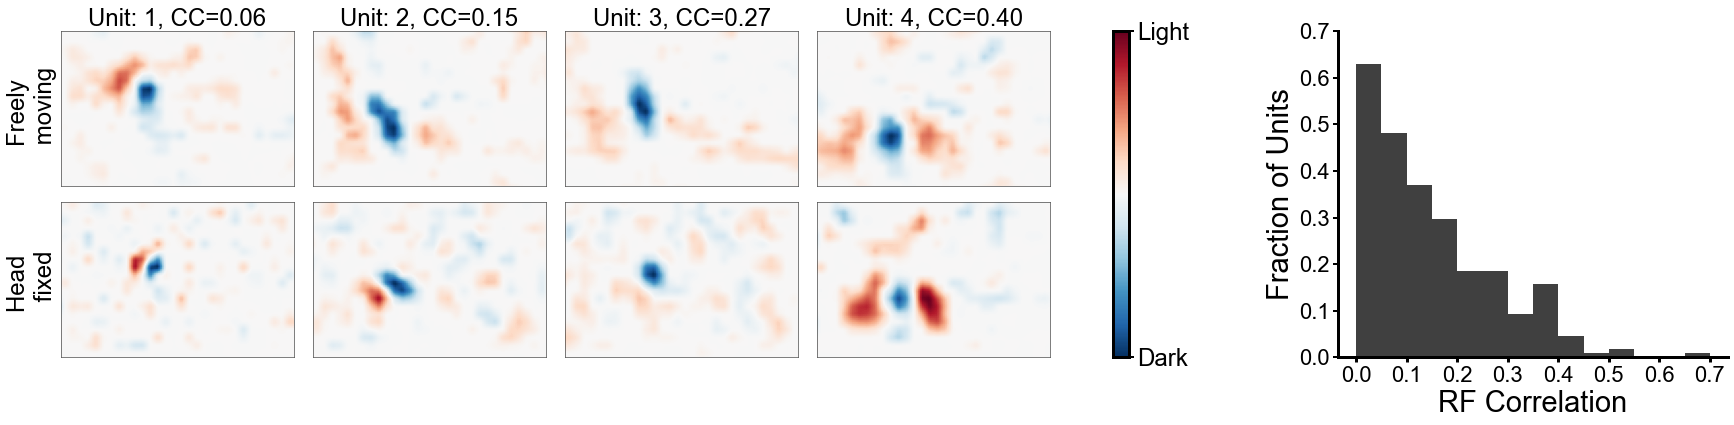

In [79]:
fontsize=24

fig1 = plt.figure(constrained_layout=False, figsize=(30,6))
gs0 = gridspec.GridSpec(ncols=4, nrows=2, figure=fig1,wspace=.1,hspace=.5)
lag_ls = [-50,0,50]
########## Fig 3A ########## 
cells = [22,61,34,101] # 
num_cells = len(cells)

gs00 = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=gs0[:,:3],wspace=.05,hspace=.1)
axs1 = np.array([fig1.add_subplot(gs00[n,m]) for n in range(2) for m in range(num_cells)]).reshape(2,num_cells)
xcut1=5
xcut2=-5
ycut1=5
ycut2=-5
for n, cell in enumerate(cells):
    crange2 = np.max(np.abs(RF_all_up[0,cell,0,int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)]))
    im2 = axs1[0,n].imshow(RF_all_up[0,cell, 0,int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)],'RdBu_r', vmin=-crange2, vmax=crange2)
    crange1 = np.max(np.abs(RF_all_up[1,cell,0,int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)]))
    im1 = axs1[1,n].imshow(RF_all_up[1,cell, 0,int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)], 'RdBu_r', vmin=-crange1, vmax=crange1)
    axs1[0,n].set_title('Unit: {}, CC={:.02f}'.format(n+1,r2_FMHF_RF[cell]), fontsize=fontsize)

axs1[1,0].set_ylabel('Head \n fixed', fontsize=fontsize)
axs1[0,0].set_ylabel('Freely \n moving', fontsize=fontsize)

cbar2 = fig1.colorbar(im1, ax=axs1.ravel().tolist())
cbar2.set_ticks([-crange1, crange1])
cbar2.set_ticklabels(['Dark', 'Light'])
cbar2.ax.tick_params(labelsize=fontsize)

for ax in axs1.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])   



########## Fig 3A ########## 
gs01 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[:,3:],wspace=.05,hspace=.1)
axs2 = fig1.add_subplot(gs01[0,0])

hbins=.05
lim0 = 0
lim1 = .75
dlim = .1
count,edges = np.histogram(np.abs(r2_FMHF_RF),bins=np.arange(lim0,lim1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
axs2.bar(edges_mid, count/len(r2_all[-1]),color='k',width=hbins, alpha=.75)
axs2.set_xlabel('RF Correlation',fontsize=fontsize+5)
axs2.set_ylabel('Fraction of Units',fontsize=fontsize+5)
axs2.set_yticks(np.arange(lim0,.8,dlim))
axs2.set_yticklabels(np.round(np.arange(lim0,.8,dlim),decimals=3),fontsize=fontsize-2)
axs2.set_xticks(np.arange(lim0,lim1,dlim))
axs2.set_xticklabels(np.round(np.arange(lim0,lim1,dlim),decimals=1), fontsize=fontsize-2)
# axs2.set_xlim(0,.8)
# axs2.set_ylim(0,.25)

plt.tight_layout()
plt.show()
# fig1.savefig(fig_dir/'HF_FM_RF_CCComparison.png', facecolor='white', transparent=True, bbox_inches='tight')

## Other Plots

### Scatter all data

In [ ]:
celltype_dir = params['data_dir'].parent.parent.parent.parent / 'batch_files/120221_hffm'
celltype_file = celltype_dir / 'pooled_ephys_population_update_120621.pickle'
celltype = pickle.load(open(celltype_file,'rb'))
date_exp = [n for n,da in enumerate(celltype['session'].unique()) if params['date_ani2'] in da][0]

celltype2 = celltype[celltype['session']==celltype['session'].unique()[date_exp]].reset_index(drop=True)
inh = celltype2['exc_or_inh'] == 'inh'
exc = celltype2['exc_or_inh'] == 'exc'
depth = celltype2['hf1_wn_depth_from_layer5']
clust, clabel = pd.factorize(celltype2['movement_psth_type_simple'])
print(celltype['session'].unique()[date_exp])


In [ ]:
bad_cells_all

In [ ]:

# celltypes_all.append([celltype2['exc_or_inh'] == 'inh',celltype2['exc_or_inh'] == 'exc',celltype2['hf1_wn_depth_from_layer5']])


In [ ]:
Kfold = 0
args['free_move']=True
mod_titles = ['Mot','Vis','Add','Mul']
mod_clrs = ["#136f63","#e0ca3c","#f34213","#80a4ed"]
dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT'] # '102621/J558NC' 
ModelList_all = []
test_std =[]
tuning_sig_all = []
NCells_all = []
bad_cells_all = []
for d,date_ani in enumerate(dates_all):
    args['date_ani'] = date_ani
    args['NoL1']=False
    args['Nepochs'] = 5000
    date_ani2 = params['save_dir'].parent.parent.parent/date_ani
    if args['NoL1'] == True: 
        L1 = 'NoL1'
        mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    else: 
        L1 = 'withL1'
        mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    ModelList = np.array(sorted(list(date_ani2.rglob(mod_name+'.h5'))))[:-1]
    ModelList_all.append(ModelList)
    params,_,_ = load_params(0,Kfold,args,debug=True)
    bad_cells = np.load(params['save_dir_hf']/'bad_cells.npy')
    bad_cells_all.append(bad_cells)
    data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    test_std.append(np.var(data['test_nsp'],axis=0))
    tuning_sig_all.append(tuning_sig2)
    NCells_all.append(len(tuning_sig2))
ModelList_all = np.stack(ModelList_all)
test_std=np.hstack(test_std)
tuning_sig_all = np.hstack(tuning_sig_all)

celltypes_all = []
for n,date_exp in enumerate([2,4,7,9]):
    celltype2 = celltype[celltype['session']==celltype['session'].unique()[date_exp]].reset_index(drop=True)
    celltype2 = celltype2.drop(bad_cells_all[n])
    celltypes_all.append([celltype2['exc_or_inh'] == 'exc',celltype2['hf1_wn_depth_from_layer5']])
    
celltypes_all = np.hstack(celltypes_all)

In [ ]:

r2_all = []
vloss_all = []
cell_tot = 0
for modeln, mod in enumerate(mod_titles):
    r2 = []
    vloss = []
    for fmod in ModelList_all[:,modeln]:
        GLM_Data = ioh5.load(fmod)
        r2.append(GLM_Data['r2_test'])
        vloss.append(np.mean(GLM_Data['vloss_trace_all'][:,-10:],axis=1))
    r2_all.append(np.hstack(r2))
    vloss_all.append(np.hstack(vloss))
r2_all = np.stack(r2_all)
vloss_all = np.stack(vloss_all)
r2_Mot,r2_Vis,r2_Add,r2_Mul = r2_all
vloss_Mot,vloss_Vis,vloss_Add,vloss_Mul = vloss_all/test_std

In [ ]:
r2_Mot.shape,r2_Vis.shape,r2_Add.shape,r2_Mul.shape, vloss_Mot.shape,vloss_Vis.shape,vloss_Add.shape,vloss_Mul.shape

In [ ]:
a = 0; l = 0
scat_clr = ["#f9c80e","#f86624","#43bccd","#662e9b"] # 
scat_clr_all = np.hstack([NCells_all[n]*[scat_clr[n]] for n in range(len(scat_clr))])
clrs_all, labels = pd.factorize(scat_clr_all)
cmap = mpl.colors.ListedColormap(scat_clr)
# scat_clr = ["#f9c80e","#f86624","#ea3546","#662e9b","#43bccd"]
thresh_fr = 1
tuning_thresh = .2
fontsize=24
bin_length=40

vals_Mot = r2_Mot[tuning_sig_all]
vals_Vis = r2_Vis[tuning_sig_all]
vals_Add = r2_Add[tuning_sig_all]
vals_Mul = r2_Mul[tuning_sig_all]
tuning_idx = np.where(tuning_sig_all)[0]
lims = (0, .6)

fig, axs = plt.subplots(2,2,figsize=(10,10))
##### Vis vs Mot #####
ax = axs[0,0]
ax.scatter(vals_Vis,vals_Mot,30,c=clrs_all[tuning_sig_all],cmap=cmap, label='Mul')
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.set_xlabel('Visual: $r^2$',fontsize=fontsize)
ax.set_ylabel('Position: $r^2$',fontsize=fontsize)
ax.set_yticks(np.arange(0,lims[1],.1))
ax.set_yticklabels(np.round(np.arange(0,lims[1],.1),decimals=1))
# for i, txt in enumerate(np.arange(len(vals_Vis))):
#     ax.annotate(tuning_idx[i], (vals_Vis[i], vals_Mot[i]),fontsize=10)

##### Vis vs Add/Mul #####
ax = axs[0,1]
ax.scatter(vals_Vis,vals_Add,30,c=mod_clrs[2], label='Add')
ax.scatter(vals_Vis,vals_Mul,30,c=mod_clrs[3], label='Mul')
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.set_xlabel('Visual: $r^2$',fontsize=fontsize)
ax.set_ylabel('Visual & Position: $r^2$',fontsize=fontsize)
ax.set_yticks(np.arange(0,lims[1],.1))
ax.set_yticklabels(np.round(np.arange(0,lims[1],.1),decimals=1))
leg = ax.legend()
for handle, text in zip(leg.legendHandles, leg.get_texts()):
    text.set_color(handle.get_facecolor()[0])
# for i, txt in enumerate(np.arange(len(vals_Vis))):
#     ax.annotate(tuning_idx[i], (vals_Vis[i], vals_Add[i]),fontsize=10,c=mod_clrs[2])
#     ax.annotate(tuning_idx[i], (vals_Vis[i], vals_Mul[i]),fontsize=10,c=mod_clrs[3])

##### MSE #####
diff = vloss_Add[tuning_sig_all]-vloss_Mul[tuning_sig_all]
increase = 1-vloss_Vis[tuning_sig_all]
th = increase>-100

NMul = np.sum(diff[th]>0)
NAdd = np.sum(diff[th]<0)
ax=axs[1,0]
ax.scatter(diff[th],increase[th],c=clrs_all[tuning_sig_all][th],cmap=cmap,s=20)
ax.axvline(x=0,c='k')
ax.set_ylabel('1-(NLVis_MSE/SD)')
ax.set_xlabel('MSE: Add-Mul')
ax.set_title('NAdd:{}, NMul:{}'.format(NAdd,NMul))
ax.set_ylim(-.05,.25)
ax.set_xlim(-.02,.02)
# for i, txt in enumerate(np.arange(len(tuning_idx[th]))):
#     ax.annotate(tuning_idx[th][i], (diff[th][i], increase[th][i]),fontsize=10)

##### R2 Explained Variance #####
diff = r2_Mul[tuning_sig_all]-r2_Add[tuning_sig_all]
increase = 1-vloss_Vis[tuning_sig_all]
th = increase>-100

NMul = np.sum(diff[th]>0)
NAdd = np.sum(diff[th]<0)
ax=axs[1,1]
im = ax.scatter(diff[th],increase[th],c=clrs_all[tuning_sig_all][th],cmap=cmap,s=20)
ax.axvline(x=0,c='k')
ax.set_ylabel('1-(NLVis_MSE/SD)')
ax.set_xlabel('R2: Mul-Add')
ax.set_title('NAdd:{}, NMul:{}'.format(NAdd,NMul))
ax.set_ylim(-.05,.25)
# for i, txt in enumerate(np.arange(len(tuning_idx[th]))):
#     ax.annotate(tuning_idx[th][i], (diff[th][i], increase[th][i]),fontsize=10)

cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])
cbar2 = fig.colorbar(im, cax=cbar_ax)
cbar2.set_ticks(np.arange(.4,3.25,.75))
cbar2.set_ticklabels(dates_all)
cbar2.ax.tick_params(labelsize=fontsize)

plt.tight_layout() 
# fig.savefig(paper_fig_dir/('ScatterComparison.png'), facecolor='white', transparent=True, bbox_inches='tight')

In [ ]:
a = 0; l = 0
scat_clr = ["#f9c80e","#f86624","#43bccd","#662e9b"] # 
scat_clr_all = np.hstack([NCells_all[n]*[scat_clr[n]] for n in range(len(scat_clr))])
clrs_all, labels = pd.factorize(scat_clr_all)
cmap = mpl.colors.ListedColormap(scat_clr)
# scat_clr = ["#f9c80e","#f86624","#ea3546","#662e9b","#43bccd"]
thresh_fr = 1
tuning_thresh = .2
fontsize=24
bin_length=40

vals_Mot = r2_Mot[tuning_sig_all]
vals_Vis = r2_Vis[tuning_sig_all]
vals_Add = r2_Add[tuning_sig_all]
vals_Mul = r2_Mul[tuning_sig_all]
tuning_idx = np.where(tuning_sig_all)[0]
lims = (0, .6)

cell_T = 0
fig, axs = plt.subplots(2,2,figsize=(10,10))
##### Vis vs Mot #####
ax = axs[0,0]
ax.scatter(vals_Vis,vals_Mot,30,c=celltypes_all[cell_T][tuning_sig_all],cmap=cmap, label='Mul')
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.set_xlabel('Visual: $r^2$',fontsize=fontsize)
ax.set_ylabel('Position: $r^2$',fontsize=fontsize)
ax.set_yticks(np.arange(0,lims[1],.1))
ax.set_yticklabels(np.round(np.arange(0,lims[1],.1),decimals=1))
# for i, txt in enumerate(np.arange(len(vals_Vis))):
#     ax.annotate(tuning_idx[i], (vals_Vis[i], vals_Mot[i]),fontsize=10)

##### Vis vs Add/Mul #####
ax = axs[0,1]
ax.scatter(vals_Vis,vals_Add,30,c=mod_clrs[2], label='Add')
ax.scatter(vals_Vis,vals_Mul,30,c=mod_clrs[3], label='Mul')
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.set_xlabel('Visual: $r^2$',fontsize=fontsize)
ax.set_ylabel('Visual & Position: $r^2$',fontsize=fontsize)
ax.set_yticks(np.arange(0,lims[1],.1))
ax.set_yticklabels(np.round(np.arange(0,lims[1],.1),decimals=1))
leg = ax.legend()
for handle, text in zip(leg.legendHandles, leg.get_texts()):
    text.set_color(handle.get_facecolor()[0])
# for i, txt in enumerate(np.arange(len(vals_Vis))):
#     ax.annotate(tuning_idx[i], (vals_Vis[i], vals_Add[i]),fontsize=10,c=mod_clrs[2])
#     ax.annotate(tuning_idx[i], (vals_Vis[i], vals_Mul[i]),fontsize=10,c=mod_clrs[3])

##### MSE #####
diff = vloss_Add[tuning_sig_all]-vloss_Mul[tuning_sig_all]
increase = 1-vloss_Vis[tuning_sig_all]
th = increase>-100

NMul = np.sum(diff[th]>0)
NAdd = np.sum(diff[th]<0)
ax=axs[1,0]
ax.scatter(diff[th],increase[th],c=celltypes_all[cell_T][tuning_sig_all][th],cmap=cmap,s=20)
ax.axvline(x=0,c='k')
ax.set_ylabel('1-(NLVis_MSE/SD)')
ax.set_xlabel('MSE: Add-Mul')
ax.set_title('NAdd:{}, NMul:{}'.format(NAdd,NMul))
ax.set_ylim(-.05,.25)
ax.set_xlim(-.02,.02)
# for i, txt in enumerate(np.arange(len(tuning_idx[th]))):
#     ax.annotate(tuning_idx[th][i], (diff[th][i], increase[th][i]),fontsize=10)

##### R2 Explained Variance #####
diff = r2_Mul[tuning_sig_all]-r2_Add[tuning_sig_all]
increase = 1-vloss_Vis[tuning_sig_all]
th = increase>-100

NMul = np.sum(diff[th]>0)
NAdd = np.sum(diff[th]<0)
ax=axs[1,1]
im = ax.scatter(diff[th],increase[th],c=celltypes_all[cell_T][tuning_sig_all][th],cmap=cmap,s=20)
ax.axvline(x=0,c='k')
ax.set_ylabel('1-(NLVis_MSE/SD)')
ax.set_xlabel('R2: Mul-Add')
ax.set_title('NAdd:{}, NMul:{}'.format(NAdd,NMul))
ax.set_ylim(-.05,.25)
# for i, txt in enumerate(np.arange(len(tuning_idx[th]))):
#     ax.annotate(tuning_idx[th][i], (diff[th][i], increase[th][i]),fontsize=10)

cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])
cbar2 = fig.colorbar(im, cax=cbar_ax)
cbar2.set_ticks([0,1])
cbar2.set_ticklabels(['inh','exc'])
# cbar2.ax.tick_params(labelsize=fontsize)

plt.tight_layout() 
fig.savefig(paper_fig_dir/('ScatterComparison_InhExc.png'), facecolor='white', transparent=True, bbox_inches='tight')

In [ ]:
vloss_all.shape,test_std.shape

### Raster Plots

In [ ]:

ephys_file = save_dir/'RawEphysData.h5'
ephys_data = pd.read_hdf(ephys_file)
spikeT = ephys_data['spikeT']
Tmax = 5
cell_spikes = []
for celln,spks in spikeT.iteritems():
    cell_spikes.append(spks[(spks>0) &(spks < Tmax)])


In [ ]:
fontsize=24
fig,axs = plt.subplots(figsize=(5,5))
ax = axs
ax.eventplot(cell_spikes,color='k',linelengths=.5)
ax.set_xlabel('Time (sec)',fontsize=fontsize+5)
ax.set_ylabel('Cell #',fontsize=fontsize+5)
ax.set_yticks(np.arange(0,params['Ncells'],2))
ax.set_yticklabels(np.arange(0, params['Ncells'], 2),fontsize=fontsize)
ax.set_xticks(np.arange(0, 6, 2))
ax.set_xticklabels(np.arange(0, 6, 2), fontsize=fontsize)

plt.show()
fig.savefig(fig_dir/'SpikeRaster.pdf', facecolor='white', transparent=True, bbox_inches='tight')


### WorldCam/EyeCam/IMU Example

In [ ]:
celln = 12
bin_length=40
titles = np.array(['theta', 'phi', 'rho', 'omega'])
clrs = ['blue', 'orange', 'green', 'red']
fontsize=24
fig, axs = plt.subplots(4,1,figsize=(10,5),sharex=True)
for modeln,ax in enumerate(axs):
    sp_smooth = ((np.convolve(GLM_Vis['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
    smooth_move = np.zeros((len(titles), sp_smooth.shape[0]))
    smooth1 = ((np.convolve(move_test[:,modeln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
    smooth_move[modeln] = (smooth1 - np.nanmean(smooth1))/np.max(smooth1)
    ax.plot(np.arange(smooth_move[modeln].shape[0])*params['model_dt'], smooth_move[modeln],c=clrs[modeln], label=r'$\{}$'.format(titles[modeln]),alpha=.75)
    ax.set_yticks([])
axs[-1].tick_params(axis='x', labelsize=fontsize)
axs[-1].set_xlabel('Time (sec)',fontsize=fontsize)
fig.savefig(fig_dir/'IMU_Example.pdf', facecolor='white', transparent=True, bbox_inches='tight')


In [ ]:
WC_raw = np.load('/home/seuss/Research/SensoryMotorPred_Data/data/070921/J553RT/fm1/uncorrected_worldcam_dt050.npy')

In [ ]:
WC_raw.shape,data['model_vid_sm'].shape

In [ ]:
fig,axs = plt.subplots(1,figsize=(2,2))
# axs.imshow(WC_raw[1000], cmap='gray')
axs.imshow(model_vid_sm_shift[2000], cmap='gray')
axs.axis('off')
fig.savefig(fig_dir/'WC_DSIm.pdf', facecolor='white', transparent=True, bbox_inches='tight')

# axs[1].imshow(model_vid_sm_shift[1000])

### Position Only

In [ ]:
celln = 101
bin_length=40
Nepochs = 5000
fontsize = 24
for Kfold in range(3):
    move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    GLM_Mot = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Mot',int(params['model_dt']*1000), params['nt_glm_lag'], 0, Nepochs, Kfold))
    GLM_Vis = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), params['nt_glm_lag'], 1, 12000, Kfold))
    GLM_Add = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Add',int(params['model_dt']*1000), params['nt_glm_lag'], 2, Nepochs, Kfold))
    GLM_Mul = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Mul',int(params['model_dt']*1000), params['nt_glm_lag'], 2, Nepochs, Kfold))

    fig,ax = plt.subplots(figsize=(20,5))
    sp_smooth = ((np.convolve(GLM_Vis['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]

    pred_smooth_Mot = ((np.convolve(GLM_Mot['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
    pred_smooth_Vis = ((np.convolve(GLM_Vis['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]

    pred_smooth_Add = ((np.convolve(GLM_Add['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
    pred_smooth_Mul = ((np.convolve(GLM_Mul['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]

    ax.plot(np.arange(len(sp_smooth))*params['model_dt'],sp_smooth, 'k', lw=2,label='Actual')
    ax.plot(np.arange(len(pred_smooth_Mot))*params['model_dt'],pred_smooth_Mot,'r', lw=2,label='Mot')
    ax.plot(np.arange(len(pred_smooth_Vis))*params['model_dt'],pred_smooth_Vis,'b', lw=2,label='Vis')
    ax.plot(np.arange(len(pred_smooth_Add))*params['model_dt'],pred_smooth_Add,'m', lw=2,label='Add')
    ax.plot(np.arange(len(pred_smooth_Mul))*params['model_dt'],pred_smooth_Mul,'g', lw=2,label='Mul')
    ax.legend(labelcolor='linecolor', fontsize=18, handlelength=0, handletextpad=0, fancybox=True)
    ax.set_xlabel('Time (s)',fontsize=fontsize)
    ax.set_ylabel('Spike Rate',fontsize=fontsize)
    r2_Mot = np.corrcoef(sp_smooth,pred_smooth_Mot)[0,1]**2
    r2_Vis = np.corrcoef(sp_smooth,pred_smooth_Vis)[0,1]**2
    r2_Add = np.corrcoef(sp_smooth,pred_smooth_Add)[0,1]**2
    r2_Mul = np.corrcoef(sp_smooth,pred_smooth_Mul)[0,1]**2
    ax.set_title('Kfold:{:02d}, Mot:{:.03}, Vis:{:.03}, Add:{:.03}, Mul:{:.03}'.format(Kfold, r2_Mot,r2_Vis,r2_Add,r2_Mul))
    fig.savefig(fig_dir/'ExamplePredFR_celln{}_Kfold{:02d}.png'.format(celln,Kfold), facecolor='white', transparent=True, bbox_inches='tight')


In [ ]:
Kfold = 2
Nepochs=5000
bin_length = 40
move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
GLM_Mot = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Mot',int(params['model_dt']*1000), params['nt_glm_lag'], 0, 5000, Kfold))
GLM_Vis = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), params['nt_glm_lag'], 1, 12000, Kfold))
GLM_Add = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Add',int(params['model_dt']*1000), params['nt_glm_lag'], 2, 5000, Kfold))
GLM_Mul = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Mul',int(params['model_dt']*1000), params['nt_glm_lag'], 2, 5000, Kfold))


In [ ]:

celln = 101
t = 1200
dt = 2000
fontsize=24
fig,ax = plt.subplots(figsize=(15,5))
sp_smooth = ((np.convolve(GLM_Vis['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]

pred_smooth_Mot = ((np.convolve(GLM_Mot['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
pred_smooth_Vis = ((np.convolve(GLM_Vis['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
pred_smooth_Add = ((np.convolve(GLM_Add['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
pred_smooth_Mul = ((np.convolve(GLM_Mul['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]

r2_Mot = np.corrcoef(sp_smooth,pred_smooth_Mot)[0,1]**2
r2_Vis = np.corrcoef(sp_smooth,pred_smooth_Vis)[0,1]**2
r2_Add = np.corrcoef(sp_smooth,pred_smooth_Add)[0,1]**2
r2_Mul = np.corrcoef(sp_smooth,pred_smooth_Mul)[0,1]**2

ax.plot(np.arange(len(sp_smooth[t:t+dt]))*params['model_dt'],sp_smooth[t:t+dt], 'k', lw=5,label='Actual', zorder=0)
ax.plot(np.arange(len(pred_smooth_Mot[t:t+dt]))*params['model_dt'],pred_smooth_Mot[t:t+dt],'r', lw=5,label='Pos: $r^2$={:.02f}'.format(r2_Mot), zorder=4)
ax.plot(np.arange(len(pred_smooth_Vis[t:t+dt]))*params['model_dt'],pred_smooth_Vis[t:t+dt],'b', lw=5,label='Vis: $r^2$={:.02f}'.format(r2_Vis), zorder=3)
ax.plot(np.arange(len(pred_smooth_Add[t:t+dt]))*params['model_dt'],pred_smooth_Add[t:t+dt],'m', lw=5,label='Add: $r^2$={:.02f}'.format(r2_Add), zorder=2)
ax.plot(np.arange(len(pred_smooth_Mul[t:t+dt]))*params['model_dt'],pred_smooth_Mul[t:t+dt],'g', lw=5,label='Mul: $r^2$={:.02f}'.format(r2_Mul), zorder=1)
ax.legend(labelcolor='linecolor', fontsize=18, handlelength=0, handletextpad=0, fancybox=True, bbox_to_anchor=(1.01, 1))
ax.set_xlabel('Time (s)',fontsize=fontsize)
ax.set_ylabel('sp/sec',fontsize=fontsize)

fig.savefig(fig_dir/'Mul_ExamplePredFR_celln{}_Kfold{:02d}.pdf'.format(celln,Kfold), facecolor='white', transparent=True, bbox_inches='tight')

# Cell Type

In [ ]:
celltype['session'].unique()

In [ ]:
celltype_dir = params_m1['data_dir'].parent.parent.parent.parent / 'batch_files/120221_hffm'
celltype_file = celltype_dir / 'pooled_ephys_population_update_120621.pickle'
celltype = pickle.load(open(celltype_file,'rb'))
celltype2 = celltype[celltype['session']==celltype['session'].unique()[2]].reset_index(drop=True)
inh = celltype2['exc_or_inh'] == 'inh'
exc = celltype2['exc_or_inh'] == 'exc'
depth = celltype2['hf1_wn_depth_from_layer5']
clust, clabel = pd.factorize(celltype2['movement_psth_type_simple'])


In [ ]:
a = 0; l = 0
fontsize=24
bin_length=40
fig, axs = plt.subplots(1,3,figsize=(18,6))
ax = axs[0]
xvals = np.nanmean(r2_Vis,axis=0)[tuning_sig2] # GLM_Mot['r2_test'][tuning_sig2]
yvals = np.nanmean(r2_Mul,axis=0)[tuning_sig2] # GLM_Vis['r2_test'][tuning_sig2]
yvals2 = np.nanmean(r2_Add,axis=0)[tuning_sig2]
# yvals3 = np.nanmean(r2_AddMul,axis=0)[tuning_sig2]
tuning_idx = np.where(tuning_sig2)[0]
lim_max = np.nanmax((xvals,yvals))+1.5*np.nanstd((xvals,yvals))
lim_min = np.nanmin((xvals,yvals))-1.5*np.nanstd((xvals,yvals))
lims = (0, .51)
ax.scatter(xvals,yvals,30,c='g', label='Mul')
ax.scatter(xvals,yvals2,30,c='m', label='Add')
# ax.scatter(xvals,yvals3,30,c='k', label='AddMul')
ax.plot(np.linspace(lims[0],.5),np.linspace(lims[0],.5),'k--',zorder=0)
ax.set_xlabel('Visual: $r^2$',fontsize=fontsize)
ax.set_ylabel('Visual & Position: $r^2$',fontsize=fontsize)
ax.set_yticks(np.arange(0,.6,.1))
ax.set_yticklabels(np.round(np.arange(0,.6,.1),decimals=1))
leg = ax.legend()
for handle, text in zip(leg.legendHandles, leg.get_texts()):
    text.set_color(handle.get_facecolor()[0])
# ax.legend(labelcolor='facecolor', fontsize=18, handlelength=0, handletextpad=0, fancybox=True)
# ax.set_title('FR Thresh={}, Tuning Thresh={} \n bin_len: {}'.format(thresh_fr,tuning_thresh,bin_length))
# for i, txt in enumerate(np.arange(len(xvals))):
#     ax.annotate(tuning_idx[i], (xvals[i], yvals[i]),fontsize=10)

xvals = np.nanmean(r2_Add,axis=0) - np.nanmean(r2_Vis,axis=0)# GLM_Add['r2_test'][tuning_sig2]-GLM_Vis['r2_test'][tuning_sig2]
yvals = np.nanmean(r2_Mul,axis=0) - np.nanmean(r2_Vis,axis=0)# GLM_Mul['r2_test'][tuning_sig2]-GLM_Vis['r2_test'][tuning_sig2]
lim_max = np.nanmax((xvals,yvals))+1.5*np.nanstd((xvals,yvals))
lim_min = np.nanmin((xvals,yvals))-1.5*np.nanstd((xvals,yvals))
lims = (lim_min, lim_max)
ax = axs[1]
ax.scatter(xvals[(exc)&(tuning_sig2)],yvals[(exc)&(tuning_sig2)],30,c='b',label='exc')
ax.scatter(xvals[(inh)&(tuning_sig2)],yvals[(inh)&(tuning_sig2)],30,c='g',label='inh')
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.set_xlabel('(Visual + Position) - Visual: $r^2$',fontsize=fontsize)
ax.set_ylabel('(Visual * Position) - Visual: $r^2$',fontsize=fontsize)
ax.legend()
# ax.set_title('FR Thresh={}, Tuning Thresh={} \n bin_len: {}'.format(thresh_fr,tuning_thresh,bin_length))
# for i, txt in enumerate(np.arange(len(xvals))):
#     ax.annotate(tuning_idx[i], (xvals[i], yvals[i]),fontsize=10)



xvals = np.nanmean(r2_Add,axis=0) - np.nanmean(r2_Vis,axis=0)# GLM_Add['r2_test'][tuning_sig2]-GLM_Vis['r2_test'][tuning_sig2]
yvals = np.nanmean(r2_Mul,axis=0) - np.nanmean(r2_Vis,axis=0)# GLM_Mul['r2_test'][tuning_sig2]-GLM_Vis['r2_test'][tuning_sig2]
lim_max = np.nanmax((xvals,yvals))+1.5*np.nanstd((xvals,yvals))
lim_min = np.nanmin((xvals,yvals))-1.5*np.nanstd((xvals,yvals))
lims = (lim_min, lim_max)
ax = axs[2]
p = ax.scatter(xvals[tuning_sig2],yvals[tuning_sig2],30,c=depth[tuning_sig2])
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.set_xlabel('(Visual + Position) - Visual: $r^2$',fontsize=fontsize)
ax.set_ylabel('(Visual * Position) - Visual: $r^2$',fontsize=fontsize)
cbar = add_colorbar(p)
plt.tight_layout()
# fig.savefig(fig_dir/'VisMov_ADDMUL_CTypeDepth_binlen{}_Kfold{:02d}.png'.format(bin_length,Kfold), facecolor='white', transparent=True, bbox_inches='tight')



In [ ]:
vloss_Vis = np.mean(GLM_Vis['vloss_trace_all'][:,:100],axis=1)/np.mean(GLM_Vis['vloss_trace_all'][:,:100])
vloss_Add = np.mean(GLM_Add['vloss_trace_all'][:,:100],axis=1)/np.mean(GLM_Add['vloss_trace_all'][:,:100])
vloss_Mul = np.mean(GLM_Mul['vloss_trace_all'][:,:100],axis=1)/np.mean(GLM_Mul['vloss_trace_all'][:,:100])


In [ ]:
Nepochs = 5000
params['NKfold']=1
vloss_Mot = np.zeros((params['NKfold'],output_size))
vloss_Vis = np.zeros((params['NKfold'],output_size))
vloss_Add = np.zeros((params['NKfold'],output_size))
vloss_Mul = np.zeros((params['NKfold'],output_size))
vloss_AddMul = np.zeros((params['NKfold'],output_size))
for Kfold in range(params['NKfold']):
    move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    # GLM_Mot = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Mot',int(params['model_dt']*1000), params['nt_glm_lag'], 0, Nepochs,Kfold))
    GLM_Vis = ioh5.load(params_m1['save_model']/'GLM_{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Vis_NoL1',int(params['model_dt']*1000), params['nt_glm_lag'], 1, Nepochs, Kfold))
    GLM_Add = ioh5.load(params_m2['save_model']/'GLM_{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Add_NoL1',int(params['model_dt']*1000), params['nt_glm_lag'], 2, Nepochs,Kfold))
    GLM_Mul = ioh5.load(params_m3['save_model']/'GLM_{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Mul_NoL1',int(params['model_dt']*1000), params['nt_glm_lag'], 3, Nepochs,Kfold))
    # GLM_AddMul = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_AddMul',int(params['model_dt']*1000), params['nt_glm_lag'], 2, 10000,Kfold))
    # r2_Mot[Kfold] = GLM_Mot['r2_test'].copy()
    vloss_Vis[Kfold] = np.mean(GLM_Vis['vloss_trace_all'][:,-100:],axis=1)/np.var(data['test_nsp'],axis=0)
    vloss_Add[Kfold] = np.mean(GLM_Add['vloss_trace_all'][:,-100:],axis=1)/np.var(data['test_nsp'],axis=0)
    vloss_Mul[Kfold] = np.mean(GLM_Mul['vloss_trace_all'][:,-100:],axis=1)/np.var(data['test_nsp'],axis=0)
    # r2_AddMul[Kfold] = GLM_AddMul['r2_test'].copy()

In [ ]:
a = 0; l = 0
fontsize=24
bin_length=40
fig, axs = plt.subplots(1,3,figsize=(18,6))
ax = axs[0]
xvals = np.nanmean(vloss_Vis,axis=0)[tuning_sig2] # GLM_Mot['r2_test'][tuning_sig2]
yvals = np.nanmean(vloss_Mul,axis=0)[tuning_sig2] # GLM_Vis['r2_test'][tuning_sig2]
yvals2 = np.nanmean(vloss_Add,axis=0)[tuning_sig2]
# yvals3 = np.nanmean(r2_AddMul,axis=0)[tuning_sig2]
tuning_idx = np.where(tuning_sig2)[0]
lim_max = np.nanmax((xvals,yvals))+1.5*np.nanstd((xvals,yvals))
lim_min = np.nanmin((xvals,yvals))-1.5*np.nanstd((xvals,yvals))
lims = (lim_min,lim_max)
ax.scatter(xvals,yvals,30,c='g', label='Mul')
ax.scatter(xvals,yvals2,30,c='m', label='Add')
# ax.scatter(xvals,yvals3,30,c='k', label='AddMul')
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.set_xlabel('Visual: $r^2$',fontsize=fontsize)
ax.set_ylabel('Visual & Position: $r^2$',fontsize=fontsize)
# ax.set_yticks(np.arange(0,.6,.1))
# ax.set_yticklabels(np.round(np.arange(0,.6,.1),decimals=1))
leg = ax.legend()
for handle, text in zip(leg.legendHandles, leg.get_texts()):
    text.set_color(handle.get_facecolor()[0])
# ax.legend(labelcolor='facecolor', fontsize=18, handlelength=0, handletextpad=0, fancybox=True)
# ax.set_title('FR Thresh={}, Tuning Thresh={} \n bin_len: {}'.format(thresh_fr,tuning_thresh,bin_length))
# for i, txt in enumerate(np.arange(len(xvals))):
#     ax.annotate(tuning_idx[i], (xvals[i], yvals[i]),fontsize=10)

xvals = (np.nanmean(vloss_Add,axis=0) - np.nanmean(vloss_Vis,axis=0))# GLM_Add['r2_test'][tuning_sig2]-GLM_Vis['r2_test'][tuning_sig2]
yvals = (np.nanmean(vloss_Mul,axis=0) - np.nanmean(vloss_Vis,axis=0))# GLM_Mul['r2_test'][tuning_sig2]-GLM_Vis['r2_test'][tuning_sig2]
lim_max = np.nanmax((xvals[tuning_sig2],yvals[tuning_sig2]))+1.5*np.nanstd((xvals[tuning_sig2],yvals[tuning_sig2]))
lim_min = np.nanmin((xvals[tuning_sig2],yvals[tuning_sig2]))-1.5*np.nanstd((xvals[tuning_sig2],yvals[tuning_sig2]))
lims = (lim_min, lim_max)
ax = axs[1]
ax.scatter(xvals[(exc)&(tuning_sig2)],yvals[(exc)&(tuning_sig2)],30,c='b',label='exc')
ax.scatter(xvals[(inh)&(tuning_sig2)],yvals[(inh)&(tuning_sig2)],30,c='g',label='inh')
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.set_xlabel('(Visual + Position) - Visual: $r^2$',fontsize=fontsize)
ax.set_ylabel('(Visual * Position) - Visual: $r^2$',fontsize=fontsize)
ax.legend()
# ax.set_title('FR Thresh={}, Tuning Thresh={} \n bin_len: {}'.format(thresh_fr,tuning_thresh,bin_length))
# for i, txt in enumerate(np.arange(len(xvals))):
#     ax.annotate(tuning_idx[i], (xvals[i], yvals[i]),fontsize=10)


xvals = (np.nanmean(vloss_Add,axis=0) - np.nanmean(vloss_Vis,axis=0))[tuning_sig2]# GLM_Add['r2_test'][tuning_sig2]-GLM_Vis['r2_test'][tuning_sig2]
yvals = (np.nanmean(vloss_Mul,axis=0) - np.nanmean(vloss_Vis,axis=0))[tuning_sig2]# GLM_Mul['r2_test'][tuning_sig2]-GLM_Vis['r2_test'][tuning_sig2]
lim_max = np.nanmax((xvals,yvals))#+1.5*np.nanstd((xvals,yvals))
lim_min = np.nanmin((xvals,yvals))#-1.5*np.nanstd((xvals,yvals))
lims = (lim_min, lim_max)
ax = axs[2]
p = ax.scatter(xvals,yvals,30,c=depth[tuning_sig2])
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.set_xlabel('(Visual + Position) - Visual: $r^2$',fontsize=fontsize)
ax.set_ylabel('(Visual * Position) - Visual: $r^2$',fontsize=fontsize)
cbar = add_colorbar(p)
plt.tight_layout()
# fig.savefig(fig_dir/'VisMov_ADDMUL_CTypeDepth_binlen{}_Kfold{:02d}.png'.format(bin_length,Kfold), facecolor='white', transparent=True, bbox_inches='tight')



In [ ]:
Kfold = 0
fig,axs = plt.subplots(1,1,figsize=(5,5))
ax = axs
diff_exc = vloss_Add[Kfold][(exc)&(tuning_sig2)]-vloss_Mul[Kfold][(exc)&(tuning_sig2)]
diff_inh = vloss_Add[Kfold][(inh)&(tuning_sig2)]-vloss_Mul[Kfold][(inh)&(tuning_sig2)]
increase_exc = 1-vloss_Vis[Kfold][(exc)&(tuning_sig2)]
increase_inh = 1-vloss_Vis[Kfold][(inh)&(tuning_sig2)]
th_exc = increase_exc>.01
th_inh = increase_inh>.01

NMul = np.sum(diff_exc[th_exc]>0)+np.sum(diff_inh[th_inh]>0)
NAdd = np.sum(diff_exc[th_exc]<0)+np.sum(diff_inh[th_inh]<0)

ax.scatter(diff_exc[th_exc],increase_exc[th_exc],c='b')
ax.scatter(diff_inh[th_inh],increase_inh[th_inh],c='g')
ax.axvline(x=0,c='k')
ax.set_ylabel('Var. Explained')
ax.set_xlabel('MSE: Add-Mul')
ax.set_title('NAdd:{}, NMul:{}'.format(NAdd,NMul))
ax.set_ylim(0,.3)
plt.tight_layout()

# fig.savefig(fig_dir/'NLVis_AddMul_MSEComparison_Kfold{:02d}.png'.format(Kfold), facecolor='white', transparent=True, bbox_inches='tight')


In [ ]:
# plt.plot(np.nanmean(vloss_Vis,axis=0))
Kfold = 0
fig, axs = plt.subplots(1,3, figsize=(15,5))
ax = axs[0]
ax.plot(vloss_Add[Kfold][tuning_sig2]-vloss_Vis[Kfold][tuning_sig2],'m')
ax.plot(vloss_Mul[Kfold][tuning_sig2]-vloss_Vis[Kfold][tuning_sig2],'g')
ax.axhline(y=0,color='k')

ax = axs[1]
ax.plot(vloss_Add[Kfold][tuning_sig2]-vloss_Mul[Kfold][tuning_sig2])
ax.axhline(y=0,color='k')
ax.set_ylabel('Add-Mul')

ax = axs[2]
ax.scatter(vloss_Add[Kfold][(exc)&(tuning_sig2)]-vloss_Mul[Kfold][(exc)&(tuning_sig2)],1-vloss_Vis[Kfold][(exc)&(tuning_sig2)])
ax.scatter(vloss_Add[Kfold][(inh)&(tuning_sig2)]-vloss_Mul[Kfold][(inh)&(tuning_sig2)],1-vloss_Vis[Kfold][(inh)&(tuning_sig2)])
ax.axvline(x=0,c='k')

plt.tight_layout()
print(np.sum(vloss_Add[Kfold][(exc)&(tuning_sig2)]-vloss_Mul[Kfold][(exc)&(tuning_sig2)]>0))
print(np.sum(vloss_Add[Kfold][(exc)&(tuning_sig2)]-vloss_Mul[Kfold][(exc)&(tuning_sig2)]<0))

Run on nonlinear fit for metic MSE. 

In [ ]:
################################################

fig,axs = plt.subplots(1,1,figsize=(7,7))
ax = axs
diff = vloss_Add[Kfold][tuning_sig2]-vloss_Mul[Kfold][tuning_sig2]
increase = 1-vloss_Vis[Kfold][tuning_sig2]
th = increase>-10

NMul = np.sum(diff[th]>0)
NAdd = np.sum(diff[th]<0)

ax.scatter(diff[th],increase[th],c='b',s=20)
ax.axvline(x=0,c='k')
ax.set_ylabel('1-(NLVis_MSE/SD)')
ax.set_xlabel('MSE: Add-Mul')
ax.set_title('NAdd:{}, NMul:{}'.format(NAdd,NMul))
ax.set_ylim(-.05,.3)
ax.set_xlim(-.02,.02)

for i, txt in enumerate(np.arange(len(tuning_idx[th]))):
    ax.annotate(tuning_idx[th][i], (diff[th][i], increase[th][i]),fontsize=10)

plt.tight_layout()

# # fig.savefig(params_m1['fig_dir']/'NLVis_AddMul_NB12000_Kfold{:02d}.png'.format(Kfold), facecolor='white', transparent=True, bbox_inches='tight')

fig,axs = plt.subplots(1,1,figsize=(7,7))
ax = axs
diff = r2_Mul[Kfold][tuning_sig2]-r2_Add[Kfold][tuning_sig2]
increase = 1-vloss_Vis[Kfold][tuning_sig2]
th = increase>-10

NMul = np.sum(diff[th]>0)
NAdd = np.sum(diff[th]<0)

ax.scatter(diff[th],increase[th],c='b',s=20)
ax.axvline(x=0,c='k')
ax.set_ylabel('1-(NLVis_MSE/SD)')
ax.set_xlabel('R2: Mul-Add')
ax.set_title('NAdd:{}, NMul:{}'.format(NAdd,NMul))
ax.set_ylim(-.05,.3)

for i, txt in enumerate(np.arange(len(tuning_idx[th]))):
    ax.annotate(tuning_idx[th][i], (diff[th][i], increase[th][i]),fontsize=10)

plt.tight_layout() 

# fig.savefig(params_m1['fig_dir']/'NLVis_AddMul_NB12000_Kfold{:02d}.png'.format(Kfold), facecolor='white', transparent=True, bbox_inches='tight')

In [ ]:
Nepochs = 5000
params['NKfold']=1
Kfold = 0
params_m1,_,_ = load_params(1,Kfold,args,debug=True)
params_m2,_,_ = load_params(2,Kfold,args,debug=True)
params_m3,_,_ = load_params(3,Kfold,args,debug=True)

move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
malph = 0*np.ones(params_FM['Ncells'],dtype=int)

mlam = np.nanargmax(GLM_Vis['r2_test'][0],axis=0) #22*np.ones(params['Ncells'],dtype=int)# 

cellnum = np.arange(params_FM['Ncells'])

vloss_Mot = np.zeros((params['NKfold'],output_size))
vloss_Vis = np.zeros((params['NKfold'],output_size))
vloss_Add = np.zeros((params['NKfold'],output_size))
vloss_Mul = np.zeros((params['NKfold'],output_size))
r2_Vis = np.zeros((params['NKfold'],output_size))
r2_Add = np.zeros((params['NKfold'],output_size))
r2_Mul = np.zeros((params['NKfold'],output_size))
vloss_Vis[Kfold] = np.mean(GLM_Vis['vloss_trace_all'][:,-2:],axis=1)/np.var(data['test_nsp'],axis=0) #/np.var(sp_smooth,axis=0) # 
vloss_Add[Kfold] = np.mean(GLM_Add['vloss_trace_all'][:,-2:],axis=1)/np.var(data['test_nsp'],axis=0) #/np.var(sp_smooth,axis=0) # 
vloss_Mul[Kfold] = np.mean(GLM_Mul['vloss_trace_all'][:,-2:],axis=1)/np.var(data['test_nsp'],axis=0) #/np.var(sp_smooth,axis=0) # 


r2_Vis[Kfold] = GLM_Vis['r2_test'][0,mlam,cellnum].copy()
r2_Add[Kfold] = GLM_Add['r2_test'].copy()
r2_Mul[Kfold] = GLM_Mul['r2_test'].copy()


In [ ]:
GLM_Vis['r2_test'].shape

In [ ]:
np.var(GLM_Vis['pred_test'],axis=0)/model_dt